# ALGO-TRADING PIPELINE WITH LSTMS

- The goal of this project is to present a pipeline for predicting stock prices with LSTM-based deep learning models.
- I demonstrate how to predict the adjusted closing price of a stock at the next day, based on its prices during a number of previous days.
- The models raise in complexity, up to a state-of-the-art CNN-LSTM architecture. 

# Information

## Bibliography

**Algo-trading reviews - no reinforcement learning**

A survey on machine learning for stock price prediction: algorithms and techniques

http://dx.doi.org/10.5220/0009340700630071
https://www.scitepress.org/Papers/2020/93407/93407.pdf

Algorithmic Trading and Financial Forecasting Using Advanced Artificial Intelligence Methodologies

https://doi.org/10.3390/math10183302

Deep Learning for Stock Market Prediction

https://doi.org/10.3390/e22080840

\

**Algo-trading reviews**

Stock Market Prediction via Deep Learning Techniques: A Survey

https://arxiv.org/abs/2212.12717

An Overview of Machine Learning, Deep Learning, and Reinforcement Learning-Based Techniques in Quantitative Finance: Recent Progress and Challenges

https://doi.org/10.3390/app13031956

Deep Reinforcement Learning in Quantitative Algorithmic Trading: A Review

https://arxiv.org/abs/2106.00123

\

**Sequence models**

Comparative Study of Machine Learning Models for Stock Price Prediction

https://arxiv.org/abs/2202.03156

A CNN-LSTM-Based Model to Forecast Stock Prices

https://doi.org/10.1155/2020/6622927

A CNN–LSTM model for gold price time-series forecasting

https://doi.org/10.1007/s00521-020-04867-x

Evaluation of bidirectional LSTM for short-and long-term stock market prediction

https://doi.org/10.1109/IACS.2018.8355458

Predicting stock market index using LSTM

https://doi.org/10.1016/j.mlwa.2022.100320

## Variables hierarchy

- data_original: symbol -> dataframe with ['Timedate', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

- data_preprocessed: symbol -> train/test -> feature type (from data_original dataframes columns)

- data_feats_and_targets: symbol -> feature type -> train/test -> features/targets -> samples (num_samples X num_time_steps X 1)

    E.g.: data_feats_and_targets['AAPL']['Adj Close']['train']['features'].shape = (1000, 60, 1)

- data_feats_and_targets_preprocessed: symbol -> feature type -> train/test -> features/targets -> samples

# Initialization

## Importing modules

In [1]:
# Importing modules

# Math
import math
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Datasets
try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf
    
# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchsummary import summary as tsummary

import tensorflow as tf
import keras
from keras.models import Sequential, Model # Sequential & functional APIs
from keras.layers import InputLayer, Input, Activation, Reshape, Flatten, concatenate
from keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.utils import plot_model
from keras.models import save_model, load_model
# tf.config.run_functions_eagerly(True)

# File management
import os
import sys
import pickle

# Misc.
import copy
import warnings
# warnings.filterwarnings('ignore')

## Working directory settings

In [2]:
# Working directory settings

is_runtime_local = True # True for local runtime, False for a hosted runtime on Google Colab

working_dir_local = "C:/Sergey\'s Google Drive/GitHub/PORTFOLIO-ALGO-TRADING/Algo_trading_pipeline_with_LSTMs/"
# working_dir_local = "C:/Google Drive/Colab Notebooks/Algo_trading_pipeline_with_LSTMs/"

working_dir_hosted = "/content/drive/My Drive/GitHub/PORTFOLIO-ALGO-TRADING/Algo_trading_pipeline_with_LSTMs/"

Connecting to local runtime command:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [3]:
# Setting working directory
if is_runtime_local:
    os.chdir(working_dir_local)

else:
    from google.colab import drive # !pip install google-colab
    drive.mount('/content/drive')
    os.chdir(working_dir_hosted)

working_directory = os.getcwd()
print('Current working directory:')
print(working_directory)

Current working directory:
C:\Sergey's Google Drive\GitHub\PORTFOLIO-ALGO-TRADING\01-Algo_trading_pipeline_with_LSTMs


## Device settings

In [4]:
# Device settings

use_gpu_if_available = True

Install CUDA with:

conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

conda install cudatoolkit

In [5]:
# Checking if a GPU is available
is_cuda_available = torch.cuda.is_available()
print('Is CUDA available:', is_cuda_available, '\n')

if is_cuda_available and use_gpu_if_available:
    device = 'cuda' if is_cuda_available else 'cpu'
    device_id = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device_id)

    print('Used device:', device)
    print('CUDA PyTorch version:', torch.version.cuda)
    print('CUDA device ID:', device_id)
    print('CUDA device name:', device_name, '\n')

else:
    device = 'cpu'
    print('Used device:', device)

Is CUDA available: True 

Used device: cuda
CUDA PyTorch version: 11.7
CUDA device ID: 0
CUDA device name: NVIDIA GeForce GTX 1050 Ti 



## Data settings

In [6]:
# Data settings

# Sections
data_download_flag = True
data_save_flag = True
data_load_flag = True

# Symbols
data_symbols = ['AAPL']
# data_symbols = sorted(['AAPL','SPY'])
# data_symbols = sorted(['SPY','VOO']) # S&P 500 EFT symbols: SPY, VOO, IVV
data_symbol_eg = data_symbols[0] # Example symbol for exploring data

# Time
data_download_by_weeks = False # Use for data which can only be downloaded per one week
data_time_interval = '1d'
data_num_days = 5*365 # For SPY, the requested dates range must be within the last 30 days, so use 29
data_today_date = pd.to_datetime('today').date()

data_end_date = pd.to_datetime('2023-03-12') # data_today_date
data_start_date = (data_end_date - pd.DateOffset(days=data_num_days)).date()
print(f'Chosen date range:\n[data_start_date, data_end_date] = [{data_start_date}, {data_end_date}]')

# Preprocessing
data_features_names = ['Adj Close','Close','High','Low','Open','Volume']

data_lookback_steps = 7
data_forecast_steps = 1

data_train_test_split = 0.8

# Paths
data_saving_directory = working_directory + '/' + 'Data/'
data_saving_file_name = 'data_' + f'{data_symbols}_'.replace("'","") + f'{data_time_interval}' + '.sav'

data_loading_directory = working_directory + '/' + 'Data/'
data_loading_file_name = data_saving_file_name

Chosen date range:
[data_start_date, data_end_date] = [2018-03-13, 2023-03-12 00:00:00]


## Features & targets settings

In [7]:
# Features and targets settings

# Preprocessing
data_denoise_rolling_flag = False
data_denoise_rolling_steps = 5
data_denoise_fft_flag = False
data_denoise_fft_psd_th_percent = 1e-4

## Machine learning settings

In [8]:
# Machine learning settings

# Sections
ml_run_lstm_single = True
ml_run_lstm_deep = True
ml_run_lstm_bidir = True
ml_run_lstm_bidir_deep = True
ml_run_cnn_lstm = True
ml_run_cnn_lstm_multiple_feats = True
ml_run_cnn_lstm_deep_bidir_multiple_feats = True
ml_run_cnn_lstm_multiple_feats_pytorch = True
ml_run_cnn_lstm_prices_indics = False

ml_train_flag = True
ml_save_flag = True
ml_load_flag = True

# Paths
simulation_id = '230313'
evaluation_saving_folder = 'Evaluations/'
evaluation_saving_file_name = f'evaluation_{data_symbol_eg}_{data_time_interval}_{simulation_id}.csv'.replace("'","")
evaluation_saving_path = evaluation_saving_folder + evaluation_saving_file_name
print(f'Saving evaluations to:\n{evaluation_saving_path}\n')

Saving evaluations to:
Evaluations/evaluation_AAPL_1d_230313.csv



## Exploration settings

In [9]:
# Exploratory data analysis settings

explore_data_flag = True

# Display
pd.set_option('display.width', 500) # For presenting full dataframes
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)
font_size = 16
tick_size = font_size - 2

## Randomization settings

In [10]:
# Randomization settings

use_fixed_random_seed_flag = True # Fix the randomization seed for reproducibility
random_seed_value = 42

In [11]:
def set_random_seed(random_seed_value):    
    ''' Set random seed. '''
    # random_seed_value = 0

    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED'] = str(random_seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(random_seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(random_seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    # tf.random.set_seed(random_seed_value)

    # For later versions: 
    tf.compat.v1.set_random_seed(random_seed_value)

    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    # K.set_session(sess)

    # For later versions:
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

    # PyTorch
    import torch
    torch.manual_seed(random_seed_value)

    return

# Data

## Collecting data

### Functions

In [12]:
def download_data(symbols, data_time_interval, data_start_date, data_end_date, download_by_weeks, show_info):
    ''' Loading stock prices data from Yahoo finance. '''

    data = {k:pd.DataFrame() for k in symbols}
    for symbol in symbols:
        if download_by_weeks:
            # Creating a dataframe with consecutive time ranges of one week durations
            start_dates = pd.date_range(start=data_start_date, end=data_end_date, freq="7D")
            end_dates = start_dates.shift(6, freq="d")
            # Verifying the latest end_date doesn't go over the specified end_date,
            # since end_dates is a shifted start_dates and might do so
            end_dates = list(end_dates)[:-1] + [min(end_dates[-1], pd.Timestamp(data_end_date))]
            dates = pd.DataFrame(data = {"start_date": start_dates, "end_date": end_dates},
                                columns = ("start_date", "end_date")
                                )
            if show_info:
                print('Dates:\n', dates,'\n')

            dfs_list = [] # Will contain a dataframe per each week
            for i in dates.index:
                start = dates.at[i, "start_date"]
                end = dates.at[i, "end_date"]
                df = yf.download(symbol, start=start, end=end, interval=data_time_interval)
                dfs_list.append(df)
            print()
            data[symbol] = pd.concat(dfs_list).reset_index().rename(columns={'Date': 'Datetime'})

        else:
            data[symbol] = yf.download(symbol, start=data_start_date, end=data_end_date, interval=data_time_interval) \
                            .reset_index().rename(columns={'Date': 'Datetime'})
            print()

    if show_info:
        symbol_eg = symbols[0]
        print(f'Data example - {symbol_eg}:\n')
        print(data[symbol_eg].head(),'\n')

    return data

In [13]:
def add_feature_types(data, symbols):
    ''' Adding new feature types to the data. '''

    for symbol in symbols:
        data_symbol = data[symbol]
        # data_symbol['change_pct'] = (data_symbol['Adj Close'] - data_symbol['Open']) / data_symbol['Open']
        # data_symbol['max_delta'] = data_symbol['High'] - data_symbol['Low']
        data[symbol] = data_symbol

    return data

### Calculation

In [14]:
# Collecting data

# Downloading data
if data_download_flag:
    data_original = download_data(data_symbols, data_time_interval, data_start_date, data_end_date,
                                  data_download_by_weeks, show_info=True)
    data_original = add_feature_types(data_original, data_symbols)

# Saving data
if data_download_flag and data_save_flag:
    saving_path = data_saving_directory + data_saving_file_name
    print('Saving data to:')
    print(saving_path, '\n')
    
    # Saving in pickle format
    if not os.path.exists(data_saving_directory):
        os.makedirs(data_saving_directory)
    pickle.dump(data_original, open(saving_path, 'wb'))

# Loading data
if data_load_flag:
    loading_path = data_loading_directory + data_loading_file_name
    print('Loading data from:')
    print(loading_path, '\n')

    data_original = pickle.load(open(loading_path, 'rb'))
    print(f'Loaded data example - {data_symbol_eg}:\n')
    print(data_original[data_symbol_eg].head(),'\n')

[*********************100%***********************]  1 of 1 completed

Data example - AAPL:

    Datetime       Open       High        Low      Close  Adj Close     Volume
0 2018-03-13  45.647499  45.875000  44.810001  44.992500  42.892311  126774000
1 2018-03-14  45.080002  45.130001  44.452499  44.610001  42.527657  117473600
2 2018-03-15  44.625000  45.060001  44.517502  44.662498  42.577698   90975200
3 2018-03-16  44.662498  44.779999  44.404999  44.505001  42.427555  157618800
4 2018-03-19  44.330002  44.367500  43.415001  43.825001  41.779301  133787200 

Saving data to:
C:\Sergey's Google Drive\GitHub\PORTFOLIO-ALGO-TRADING\01-Algo_trading_pipeline_with_LSTMs/Data/data_[AAPL]_1d.sav 

Loading data from:
C:\Sergey's Google Drive\GitHub\PORTFOLIO-ALGO-TRADING\01-Algo_trading_pipeline_with_LSTMs/Data/data_[AAPL]_1d.sav 

Loaded data example - AAPL:

    Datetime       Open       High        Low      Close  Adj Close     Volume
0 2018-03-13  45.647499  45.875000  44.810001  44.99250

## Exploring data

### Functions

In [15]:
def explore_data_prices(data, show_info, show_example_data, plot_candlesticks, plot_signals):
    # Presenting general information
    if show_info:
        print('Presenting general information:\n')
        print(data.info(), '\n')
        print('Presenting data statistics:\n')
        print(data.describe(datetime_is_numeric=True), '\n')

    # Presenting example data
    if show_example_data:
        print('Presenting example data:\n')
        print(data.head(5), '\n')

    # Plotting candlesticks
    if plot_candlesticks:
        fig = go.Figure(
            data = [go.Candlestick(x=data['Datetime'],
                                   open=data['Open'],
                                   high=data['High'],
                                   low=data['Low'],
                                   close=data['Close'])])
        fig.update_layout(
            title='Stock Prices',
            xaxis_title='Date',
            yaxis_title='Price [$]'
            )
        fig.show(renderer='colab')
        print()

    # Plotting signals
    if plot_signals:
        columns_to_plot = ['Adj Close','Close','High','Low','Open','Volume']
        fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 40))
        for i in range(0,len(columns_to_plot)):
            axes[i].plot(data[columns_to_plot[i]])
            axes[i].set_title(f'Stock data - {columns_to_plot[i]}')
            axes[i].set_xlabel('Time steps')
            axes[i].set_ylabel(f'{columns_to_plot[i]}')
        plt.show()
        print()
    
    return

### Calculation

Exploring AAPL data:

Presenting general information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Datetime   1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   Close      1258 non-null   float64       
 5   Adj Close  1258 non-null   float64       
 6   Volume     1258 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 68.9 KB
None 

Presenting data statistics:

                            Datetime         Open         High          Low        Close    Adj Close        Volume
count                           1258  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03
mean   2020-09-09 01:38:26.518283008   101.841469   103.088214   100.656810   

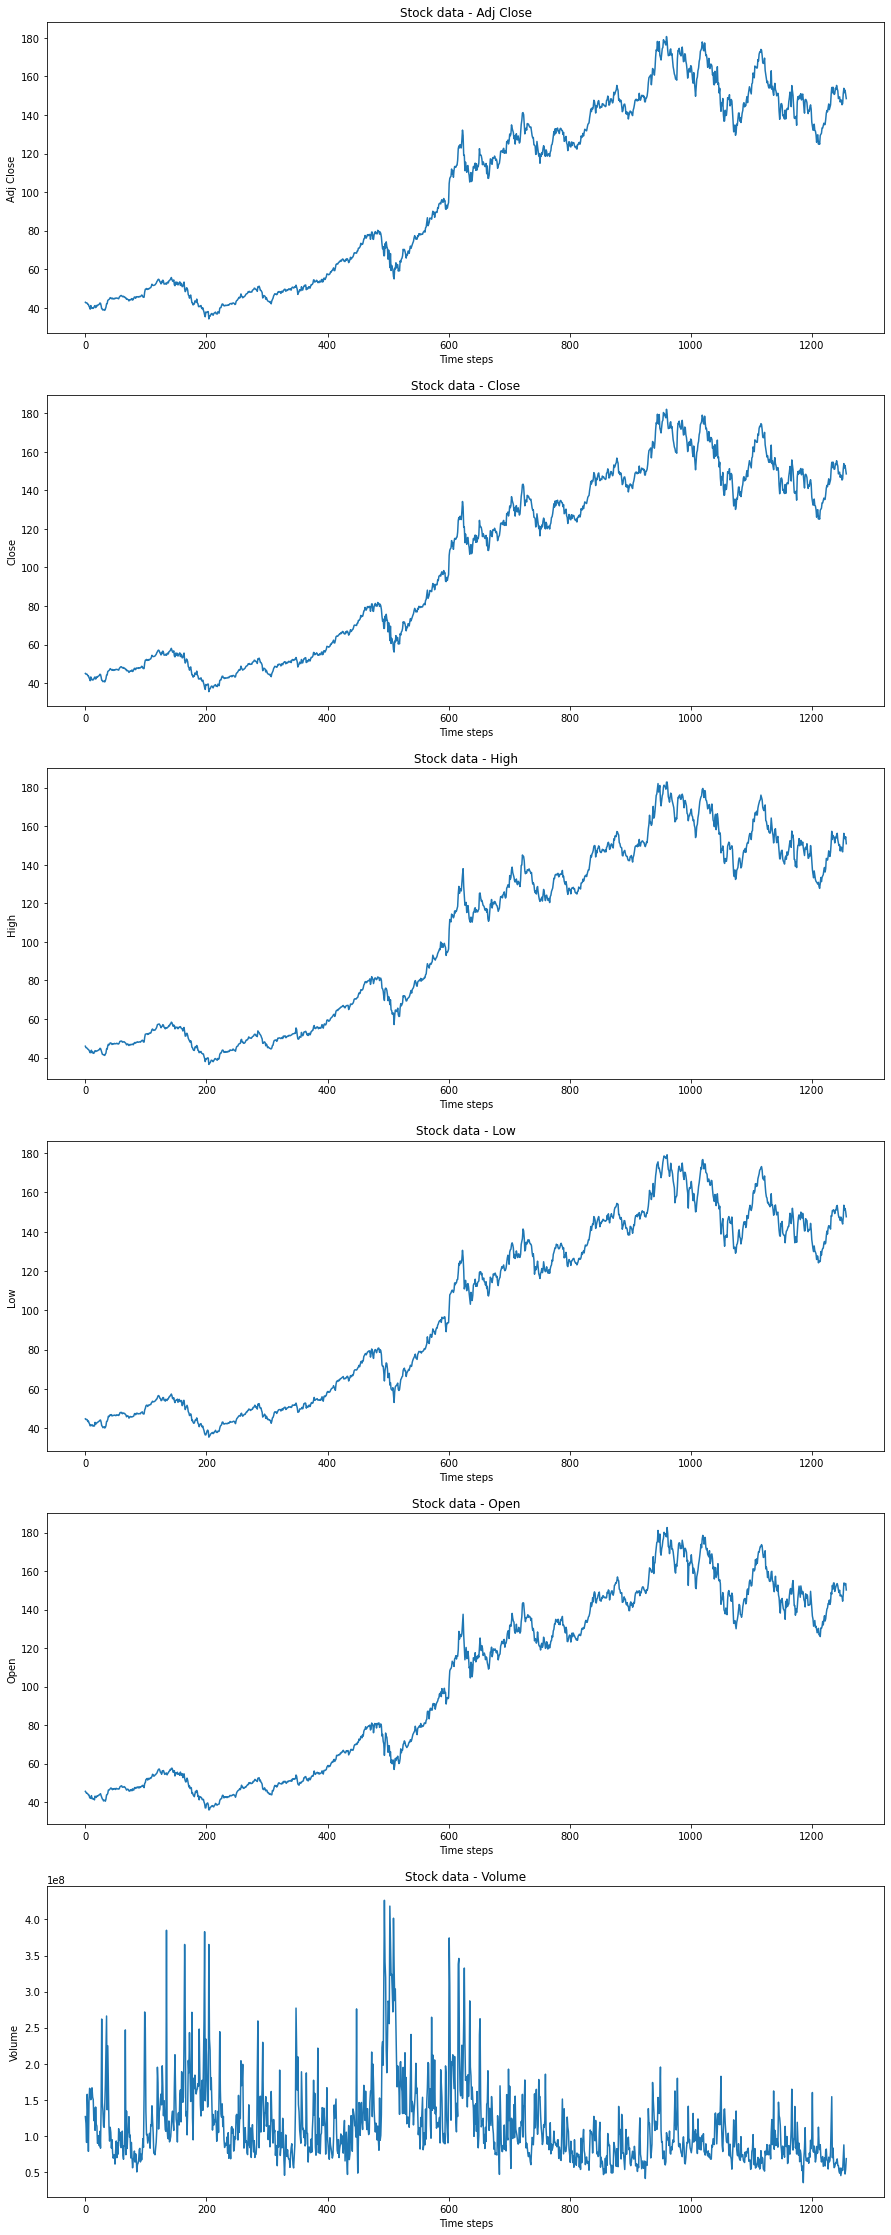

In [16]:
# Exploring data
if explore_data_flag:
    for symbol in data_symbols:
        print(f'Exploring {symbol} data:\n')
        explore_data_prices(
            data = data_original[symbol],
            show_info = True,
            show_example_data = True,
            plot_candlesticks = True,
            plot_signals = True)

## Preprocessing data

### Functions

In [17]:
def preprocess_data_types(data, show_info):
    ''' Treating data types. '''

    data['Volume'] = data['Volume'].astype('float64')

    if show_info:
        print('Treating data types.')
        explore_data_prices(
            data = data,
            show_info = True,
            show_example_data = False,
            plot_candlesticks = False,
            plot_signals = False)
        
    return data

In [18]:
def preprocess_timestamps_sorting(data, show_info):
    ''' Treating timestamps sorting. '''

    if show_info:
        print('Treating timestamps sorting.')
        print('Before:\n')
        explore_data_prices(
            data = data,
            show_info = False,
            show_example_data = True,
            plot_candlesticks = False,
            plot_signals = True)
    
    if data['Datetime'].is_monotonic:
        if show_info:
            print('The timestamps are monotonic.\n')
    else:
        print('The timestamps aren\'t monotonic!\n')
        data.sort_values(by=['Datetime'], inplace=True, ascending=True)

    if show_info:
        print('After:\n')
        explore_data_prices(
            data = data,
            show_info = False,
            show_example_data = True,
            plot_candlesticks = False,
            plot_signals = True)
        
    return data

In [19]:
def preprocess_missing_values(data, show_info):
    ''' Treating missing values. '''

    data_na_rows = data.isna().any(axis=1) # Rows with at least one missing value
    data_na_rows_num = sum(data_na_rows)
    
    if data_na_rows_num > 0:
        print('Error! Missing values found!\n')
        sys.exit()

    if show_info:
        print('Treating missing values.')
        print(f'There are {data_na_rows_num} rows with missing values.\n')

        if data_na_rows_num > 0:
            print('Presenting example rows with missing values:\n')
            print(data[data_na_rows].head())

        explore_data_prices(
            data = data,
            show_info = True,
            show_example_data = False,
            plot_candlesticks = False,
            plot_signals = False)
        
    return data

In [20]:
def preprocess_split_data(data, train_test_split, forecast_steps, show_info):
    ''' Splitting data to train and test sets. '''
    
    data_train_len = math.ceil(len(data) * train_test_split)

    data_train = data.iloc[0 : data_train_len]
    data_test = data.iloc[data_train_len-forecast_steps+1 :] # Not overlapping with the train FEATURES
    data_test = data_test.reset_index(drop=True) # Prevents issues when copying into data_test
    
    if show_info:
        print('data.shape =', data.shape)
        print('data_train.shape =', data_train.shape)
        print('data_test.shape =', data_test.shape)
        print()
        print('len(data) - (len(data_train) + len(data_test)) =', len(data) - (len(data_train) + len(data_test)))

    return data_train, data_test

In [21]:
def scale_df_cols_together(data_train, data_test, cols_to_scale, feature_range, show_info):
    ''' Scaling all training data columns together to a given range,
    then using the obtained scaling parameters to scale the testing data.
    The scaler will get a 2D array with 1 column, with shape (rows_num X 1),
    which will contain the concatenation of all the columns for scaling. '''

    # Defining objects
    num_cols = len(cols_to_scale)
    scaler = MinMaxScaler(feature_range=feature_range)

    # Scaling training data
    data_train_partial_scaled = scaler.fit_transform(
        data_train[cols_to_scale].to_numpy().reshape(-1,1))    
    data_train_partial_scaled = pd.DataFrame(data_train_partial_scaled.reshape(-1,num_cols),
                                             columns=cols_to_scale)
    data_train[cols_to_scale] = data_train_partial_scaled
    
    if show_info:
        print('cols_to_scale =', cols_to_scale, '\n')
        print('data_train_partial_scaled\n', data_train_partial_scaled.head(), '\n')
        print('data_train\n', data_train.head(), '\n')
    
    # Scaling the test data with the scaling parameters of the training data
    data_test_partial_scaled = scaler.transform(
        data_test[cols_to_scale].to_numpy().reshape(-1,1))
    data_test_partial_scaled = pd.DataFrame(data_test_partial_scaled.reshape(-1,num_cols),
                                            columns=cols_to_scale)
    data_test[cols_to_scale] = data_test_partial_scaled
    
    if show_info:
        print('data_test_partial_scaled\n', data_test_partial_scaled.head(), '\n')
        print('data_test\n', data_test.head(), '\n')
        print('#######################################################\n')

    return data_train, data_test, scaler

In [22]:
def preprocess_scale_data(data_train, data_test, show_info):
    ''' Scaling train and test data. '''

    # Defining variables
    data_train_scaled = data_train.copy(deep=True)
    data_test_scaled = data_test.copy(deep=True)
    cols_to_scale = {
        # 'prices': ['Adj Close','Close','High','Low','Open'],
        'Adj Close': ['Adj Close'],
        'Close': ['Close'],
        'High': ['High'],
        'Low': ['Low'],
        'Open': ['Open'],
        'Volume': ['Volume']
    }
    feature_range = (0,1)
    scalers = {k: None for k in cols_to_scale.keys()}
    
    # Scaling
    for cols_key in cols_to_scale.keys():
        data_train_scaled, data_test_scaled, scaler = \
            scale_df_cols_together(data_train_scaled, data_test_scaled,
                                   cols_to_scale[cols_key], feature_range, show_info=False)
        scalers[cols_key] = scaler
        
    if show_info:
        for data_to_explore in [data_train_scaled, data_test_scaled]:
            explore_data_prices(
                data = data_to_explore,
                show_info = True,
                show_example_data = True,
                plot_candlesticks = True,
                plot_signals = True)
        
    return data_train_scaled, data_test_scaled, scalers

In [23]:
def preprocess_data_prices(data, train_test_split, forecast_steps, show_info):
    ''' Preprocessing prices data. '''
    
    # Treating data types
    data = preprocess_data_types(data, show_info)

    # Verifying the timestamps are monotonic
    data = preprocess_timestamps_sorting(data, show_info)

    # Treating missing values
    data = preprocess_missing_values(data, show_info)
    
    # Splitting data
    data_train, data_test = \
        preprocess_split_data(data, train_test_split, forecast_steps, show_info)
        
    # Scaling data
    data_train_scaled, data_test_scaled, scalers = \
        preprocess_scale_data(data_train, data_test, show_info)
    
    return data, data_train_scaled, data_test_scaled, scalers

In [24]:
def preprocess_data_prices_symbols(data, train_test_split, forecast_steps, show_info):
    ''' Preprocessing prices data for multiple symbols. '''

    symbol_names = list(data.keys())
    data_preprocessed = {k:{} for k in symbol_names}
    scalers = {k:{} for k in symbol_names}

    for symbol in symbol_names:
        if show_info:
            print(f'Preprocessing prices data for {symbol}.\n')
            
        data_preprocessed_one_symbol, data_train_scaled, data_test_scaled, scalers_one_symbol = \
            preprocess_data_prices(data[symbol], train_test_split, forecast_steps, show_info)

        data_preprocessed[symbol]['data_preprocessed_one_symbol'] = data_preprocessed_one_symbol
        data_preprocessed[symbol]['data_train_scaled'] = data_train_scaled
        data_preprocessed[symbol]['data_test_scaled'] = data_test_scaled
        scalers[symbol] = scalers_one_symbol

        if show_info:
            print('#'*60, '\n')

    return data_preprocessed, scalers

### Calculation

In [25]:
# Preprocessing data
data_preprocessed, scalers = preprocess_data_prices_symbols(
    data_original, data_train_test_split, data_forecast_steps, show_info=False)

In [26]:
# Exploring preprocessed data
if explore_data_flag:
    len_train = len(data_preprocessed[data_symbol_eg]['data_train_scaled'])
    len_test = len(data_preprocessed[data_symbol_eg]['data_test_scaled'])
    
    print('len(data_original[data_symbol_eg]) =', len(data_original[data_symbol_eg]))
    print('len(data_preprocessed[data_symbol_eg]["data_train_scaled"]) =',
          len(data_preprocessed[data_symbol_eg]["data_train_scaled"]))
    print('len(data_preprocessed[data_symbol_eg]["data_test_scaled"]) =',
          len(data_preprocessed[data_symbol_eg]["data_test_scaled"]))
    print()
    print('len_train =', len_train)
    print('len_test =', len_test)
    print()
    print('data_lookback_steps =', data_lookback_steps)
    print('data_forecast_steps =', data_forecast_steps)
    print()
    print('len_train + len_test =', len_train + len_test)
    print('len_train + len_test - data_lookback_steps =', len_train + len_test - data_lookback_steps)
    print()
    print('len_train/(len_train + len_test) =', round(len_train/(len_train + len_test), 4))
    # print('len_train/(len_train + len_test + data_lookback_steps) =',
    #       round(len_train/(len_train + len_test + data_lookback_steps), 4))

len(data_original[data_symbol_eg]) = 1258
len(data_preprocessed[data_symbol_eg]["data_train_scaled"]) = 1007
len(data_preprocessed[data_symbol_eg]["data_test_scaled"]) = 251

len_train = 1007
len_test = 251

data_lookback_steps = 7
data_forecast_steps = 1

len_train + len_test = 1258
len_train + len_test - data_lookback_steps = 1251

len_train/(len_train + len_test) = 0.8005


## Features & targets - Prices

### Functions

In [27]:
def get_time_series_feats_and_targets(data, lookback_steps, forecast_steps):
    ''' Extracting time series features and targets from the data for one feature type.
    The features will contain samples of time series, beginning at increasingly shifted times.
    The targets will contain series following the corresponding training time series. '''

    # Calculating features and targets
    values = data.values
    x = []
    y = []
    
    for i in range(lookback_steps, len(data)-forecast_steps+1): # +1 since end is exclusive
        x.append(values[i-lookback_steps : i])
        y.append(values[i : i+forecast_steps])
        
    x, y = np.array(x), np.array(y)
    x = np.reshape(x, (x.shape[0], x.shape[1], 1))
    y = np.reshape(y, (y.shape[0], y.shape[1], 1))
    
    return x, y

In [28]:
def get_time_series_feats_and_targets_symbols(
    data, symbols, features_names, lookback_steps, forecast_steps):
    ''' Calculating features and targets.
    The input variables hierarchy: symbol - train/test - feature type (in dataframe column).
    The output variables hierarchy: symbol - feature type - train/test - features/targets. '''

    data_feats_and_targets = {}

    for symbol in symbols:
        data_feats_and_targets[symbol] = {}
        for feature_type in features_names:
            data_feats_and_targets[symbol][feature_type] = {}
            for data_type in ['train', 'test']:
                data_feats_and_targets[symbol][feature_type][data_type] = {}
                
                data_feats_and_targets[symbol][feature_type][data_type]['features'], \
                data_feats_and_targets[symbol][feature_type][data_type]['targets'] = \
                    get_time_series_feats_and_targets(
                        data = data[symbol][f'data_{data_type}_scaled'][feature_type],
                        lookback_steps = data_lookback_steps, 
                        forecast_steps = data_forecast_steps)
                    
    return data_feats_and_targets

### Calculation

In [29]:
# Calculating features and targets
data_feats_and_targets = get_time_series_feats_and_targets_symbols(
    data = data_preprocessed,
    symbols = data_symbols,
    features_names = data_features_names,
    lookback_steps = data_lookback_steps, 
    forecast_steps = data_forecast_steps)

## Preprocessing features & targets

### Functions

In [30]:
def fft_denoiser(signal, psd_th_percent, return_reals, show_info):
    ''' Denoises a signal using the fast fourier transform,
    by keeping the coefficients with a power spectrum density above a threshold. '''
    # Example noisy signal: np.sin(np.linspace(0,2*np.pi,100)) + np.random.uniform(-0.1,0.1,100)
    
    # Calculating the fast fourier transform
    signal_len = len(signal)
    fft = np.fft.fft(signal, signal_len)
    
    # Calculating power spectrum density = squared magnitude of each fft coefficient
    psd = fft * np.conj(fft) / signal_len

    # Filtering frequencies by PSD
    _mask = psd > psd.max() * psd_th_percent
    fft = _mask * fft
    
    # Calculating the inverse transform
    signal_denoised = np.fft.ifft(fft)
    
    # Returning the real values
    if return_reals:
        signal_denoised = signal_denoised.real
    
    # Plotting results
    if show_info:
        figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axes[0].plot(signal)
        axes[0].set_title('Signal - before')
        axes[1].plot(signal_denoised)
        axes[1].set_title('Signal - after')
        plt.show()
        print()
        
        figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axes[0].plot(fft.real)
        axes[0].set_title('FFT - Re')
        axes[1].plot(fft.imag)
        axes[1].set_title('FFT - Im')
        plt.show()
        print()

        plt.figure(figsize=(15,5))
        plt.plot(psd)
        plt.title('Power spectrum density')
        plt.show()
        print()
        print('Power spectrum density information:\n', pd.DataFrame(psd).describe(), '\n')

    return signal_denoised

In [31]:
def denoise_signal(signal, denoise_rolling_flag, denoise_rolling_steps,
    denoise_fft_flag, denoise_fft_psd_th_percent, show_info):
    ''' Remove noise from a single time series. '''
    
    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(signal)
        plt.title('Signal vs. Time steps - Before denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
    
    if denoise_rolling_flag:
        signal = pd.DataFrame(signal).rolling(denoise_rolling_steps).mean().dropna(axis=0).values

    if denoise_fft_flag:
        signal = fft_denoiser(
            signal = signal,
            psd_th_percent = denoise_fft_psd_th_percent,
            return_reals = True,
            show_info = show_info)

    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(signal)
        plt.title('Signal vs. Time steps - After denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
        print()
    
    return signal

In [32]:
def preprocess_remove_noise_features(data, denoise_rolling_flag, denoise_rolling_steps,
    denoise_fft_flag, denoise_fft_psd_th_percent, show_info):
    ''' Removing noise from features ONLY. '''

    data_denoised = copy.deepcopy(data)
    for symbol in data_symbols:
        for feature_type in ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']:
            for data_type in ['train','test']:
                x_samples = data[symbol][feature_type][data_type]['features']
                features_denoised = [] # Collecting denoised signals since they may get shortened

                for i_sample in range(0,len(x_samples)):
                    signal_1d = x_samples[i_sample,:].reshape(-1)
                    signal_denoised_1d = denoise_signal(
                        signal = signal_1d,
                        denoise_rolling_flag = denoise_rolling_flag,
                        denoise_rolling_steps = denoise_rolling_steps,
                        denoise_fft_flag = denoise_fft_flag,
                        denoise_fft_psd_th_percent = denoise_fft_psd_th_percent,
                        show_info = show_info)
                    features_denoised.append(signal_denoised_1d.reshape(-1,1))
                    
                data_denoised[symbol][feature_type][data_type]['features'] = np.array(features_denoised)

    return data_denoised

In [33]:
def denoise_signal_in_df(data, denoise_rolling_flag, denoise_rolling_steps, show_info):
    ''' Remove noise from a single time series. '''
    
    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(data)
        plt.title('Signal vs. Time steps - Before denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
    
    if denoise_rolling_flag:
        data = data.rolling(denoise_rolling_steps).mean()

    if show_info:
        figure = plt.figure(figsize=(12, 6))
        plt.plot(data)
        plt.title('Signal vs. Time steps - After denoising')
        plt.xlabel('Time steps')
        plt.ylabel('Signal')
        plt.show()
        print()

    return data

In [34]:
def preprocess_remove_noise_in_df(data, show_info):
    ''' Removing noise from prices data. '''

    data_denoised = data[['Datetime']]
    columns_to_denoise = ['Adj Close','Close','High','Low','Open','Volume']

    for column in columns_to_denoise:
        if show_info:
            print(f'Denoising "{column}".\n')
        data_denoised_one_column = denoise_signal_in_df(
            data = data[column],
            denoise_rolling_flag = False,
            denoise_rolling_steps = 5,
            denoise_fft_flag = True,

            show_info = show_info)
        data_denoised[column] = data_denoised_one_column
    
    # Removing missing values caused by denoising, e.g. by rolling mean
    data_denoised = data_denoised.dropna(axis='index').reset_index(drop=True)

    return data_denoised

### Calculation

In [35]:
# Preprocessing features and targets

# Removing noise
data_feats_and_targets_preprocessed = preprocess_remove_noise_features(
    data = data_feats_and_targets,
    denoise_rolling_flag = data_denoise_rolling_flag,
    denoise_rolling_steps = data_denoise_rolling_steps,
    denoise_fft_flag = data_denoise_fft_flag,
    denoise_fft_psd_th_percent = data_denoise_fft_psd_th_percent,
    show_info = False
    )

In [36]:
# Exploring data
if explore_data_flag:
    print(data_feats_and_targets_preprocessed.keys())
    print(data_feats_and_targets_preprocessed[data_symbol_eg].keys())
    print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close'].keys())
    print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train'].keys())
    print()
    for i in ['train','test']:
        for j in ['features','targets']:
            print(f'{i} {j}:')
            print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close'][i][j].shape)
            print(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close'][i][j][:5,0])
            print()

dict_keys(['AAPL'])
dict_keys(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'])
dict_keys(['train', 'test'])
dict_keys(['features', 'targets'])

train features:
(1000, 7, 1)
[[0.05897175]
 [0.0564814 ]
 [0.05682314]
 [0.05579777]
 [0.0513706 ]]

train targets:
(1000, 1, 1)
[[0.04087227]
 [0.0345082 ]
 [0.04725262]
 [0.04004218]
 [0.03701478]]

test features:
(244, 7, 1)
[[0.81638903]
 [0.78848927]
 [0.8188327 ]
 [0.84937985]
 [0.85637167]]

test targets:
(244, 1, 1)
[[0.9120353 ]
 [0.921471  ]
 [0.94767363]
 [0.95208599]
 [0.9580596 ]]



# Models

## Functions - Training

In [37]:
def train_model_pytorch(train_x, train_y, model, loss_function, optimizer,
    training_epochs, training_batch_size, training_validation_split):
    ''' Training model on train data and collecting evaluation metrics. '''
    
    # Defining variables
    train_x_split, val_x_split, train_y_split, val_y_split = train_test_split(
        train_x, train_y, test_size=training_validation_split, random_state=random_seed_value)
    batches_per_epoch = len(train_x_split) // training_batch_size

    train_history_dict = {'loss': [], 'val_loss': []}

    show_info_epoch_pct = 0.1 # At which percentage of the epochs to show information
    show_info_epoch_num = np.ceil(training_epochs * show_info_epoch_pct)

    for n_epoch in range(training_epochs):
        for n_batch in range(batches_per_epoch):
            # Creating mini-batch
            batch_start = training_batch_size * n_batch
            train_x_batch = train_x_split[batch_start : batch_start+training_batch_size]
            train_y_batch = train_y_split[batch_start : batch_start+training_batch_size]

            # Forward propagation
            model.train() # "Turning on" the layers needed for training
            pred_y_batch = model(train_x_batch)
            loss = loss_function(pred_y_batch, train_y_batch) # Calculating loss

            # Backward propagation
            optimizer.zero_grad() # Reset gradients of model parameters so they won't add up
            loss.backward() # Calculating gradients
            optimizer.step() # Updating weights

        # Evaluating model on validation data at the end of the epoch
        model.eval() # "Turning on" the layers needed for evaluating
        with torch.no_grad():
            pred_y_val = model(val_x_split)
            loss_val = loss_function(pred_y_val, val_y_split) # Calculating loss        

        # Saving loss history per epoch
        train_history_dict['loss'].append(loss.item())
        train_history_dict['val_loss'].append(loss_val.item())

        # Presenting information
        if n_epoch % show_info_epoch_num == 0:
            print('Epoch: {}, train loss: {:1.5f}, validation loss: {:1.5f}' \
                  .format(n_epoch, train_history_dict['loss'][-1],
                          train_history_dict['val_loss'][-1]))
    print()
    
    # Plotting loss history
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
    axes[0].plot(train_history_dict['loss'])
    axes[0].plot(train_history_dict['val_loss'])
    axes[0].set_title('Training loss vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                    %(train_history_dict['loss'][-1], train_history_dict['val_loss'][-1],
                    train_x.shape[0], training_batch_size, training_validation_split), fontsize=font_size)
    axes[0].set_ylabel('Loss', fontsize=font_size)
    axes[0].set_xlabel('Epoch', fontsize=font_size)
    axes[0].legend(['Training loss', 'Validation loss'], loc='upper right', fontsize=font_size)
    axes[0].tick_params(labelsize=tick_size)
    if True:
        axes[0].semilogy()
    plt.show()

    return

In [38]:
def train_model(
    model, outputs_names, train_x, train_y,
    model_train_flag, model_save_flag, model_load_flag, model_folder,
    training_epochs, training_batch_size, training_validation_split,
    training_verbose, training_callbacks,
    show_model_summary, 
    plot_training_loss, plot_training_metric, plot_training_metric_names, plot_log_scale):
    ''' Training a neural network model and presenting the training results. '''

    # Initializing variables
    train_history = None

    # Training the model
    if model_train_flag:
        train_history = model.fit(
            x = train_x,
            y = train_y,
            epochs = training_epochs,
            batch_size = training_batch_size,
            validation_split = training_validation_split,
            shuffle = True, # True by default
            verbose = training_verbose,
            callbacks = training_callbacks # Includes early stopping
            )
        train_history_dict = train_history.history # Converting to a dictionary
        if training_verbose > 0:
            print()

    # Saving model
    if model_train_flag and model_save_flag:
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        save_model(model, model_folder)
        print()
        print('Saved model to:')
        print(model_folder, '\n')
        
    # Loading model
    if model_load_flag:
        model = load_model(model_folder)
        print('Loaded model from:')
        print(model_folder, '\n')

    # Presenting model summary
    if show_model_summary:
        print('Presenting model summary:\n')
        model.summary()
        print()

    # Plotting training history
    if model_train_flag:
        if len(outputs_names) < 2:
            if plot_training_loss or plot_training_metric:
                fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

            # Plotting training loss
            if plot_training_loss:
                print('Final loss - Training: {:.3e}, validation: {:.3e}'.format(
                    train_history_dict['loss'][-1], train_history_dict['val_loss'][-1]))

                axes[0].plot(train_history_dict['loss']) # Training loss
                axes[0].plot(train_history_dict['val_loss']) # Validation loss
                axes[0].set_title('Training loss vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                %(train_history_dict['loss'][-1], train_history_dict['val_loss'][-1],
                                len(train_y), training_batch_size, training_validation_split), fontsize=font_size)
                axes[0].set_ylabel('Loss', fontsize=font_size)
                axes[0].set_xlabel('Epoch', fontsize=font_size)
                axes[0].legend(['Training Data', 'Validation Data'], loc='upper right', fontsize=font_size)
                axes[0].tick_params(labelsize=tick_size)
                if plot_log_scale: # Choosing whether to plot with a logarithmic scale
                    axes[0].semilogy()

            # Plotting training metric
            if plot_training_metric:
                training_metric = list(plot_training_metric_names.values())[0]
                print(f'Final {training_metric}' + ' - Training: {:.2e}, validation: {:.2e}'.format(
                    train_history_dict[f'{training_metric}'][-1], train_history_dict[f'val_{training_metric}'][-1]))

                axes[1].plot(train_history_dict[f'{training_metric}']) # Training metric
                axes[1].plot(train_history_dict[f'val_{training_metric}']) # Validation metric
                axes[1].set_title(f'Training {training_metric} vs. Epochs\n(Final {training_metric}: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                    %(train_history_dict[f'{training_metric}'][-1], train_history_dict[f'val_{training_metric}'][-1],
                    len(train_y), training_batch_size, training_validation_split), fontsize=font_size)
                axes[1].set_ylabel(f'{training_metric}', fontsize=font_size)
                axes[1].set_xlabel('Epoch', fontsize=font_size)
                axes[1].legend(['Training Data', 'Validation Data'], loc='upper right', fontsize=font_size)
                axes[1].tick_params(labelsize=tick_size)
                if plot_log_scale: # Choosing whether to plot with a logarithmic scale
                    axes[1].semilogy()

            if model_save_flag:
                plt.savefig(model_folder + 'Training_metrics.png', facecolor='white', bbox_inches='tight')

            if plot_training_loss or plot_training_metric:
                print()
                plt.show()
                print()

        else:
            # Going over the different model outputs
            for output_name in outputs_names:
                if plot_training_loss or plot_training_metric:
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

                # Plotting training loss
                if plot_training_loss:
                    print(f'Final {output_name} loss' + ' - Training: {:.3e}, validation: {:.3e}'.format(
                        train_history_dict[f'{output_name}_loss'][-1],
                        train_history_dict[f'val_{output_name}_loss'][-1]))

                    axes[0].plot(train_history_dict[f'{output_name}_loss']) # Training loss
                    axes[0].plot(train_history_dict[f'val_{output_name}_loss']) # Validation loss
                    axes[0].set_title(f'Training {output_name} loss' + ' vs. Epochs\n(Final loss: Training - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                    %(train_history_dict[f'{output_name}_loss'][-1],
                                    train_history_dict[f'val_{output_name}_loss'][-1],
                                    len(train_x), training_batch_size, training_validation_split), fontsize=font_size)
                    axes[0].set_ylabel('Loss', fontsize=font_size)
                    axes[0].set_xlabel('Epoch', fontsize=font_size)
                    axes[0].legend(['Training Data', 'Validation Data'], loc='best', fontsize=font_size)
                    axes[0].tick_params(labelsize=tick_size)
                    if plot_log_scale:
                        axes[0].semilogy()

                # Plotting training metric
                if plot_training_metric:
                    training_metric = plot_training_metric_names[output_name]
                    print(f'Final {output_name} {training_metric}' + ' - Training: {:.2%}, validation: {:.2%}'.format(
                        train_history_dict[f'{output_name}_{training_metric}'][-1],
                        train_history_dict[f'val_{output_name}_{training_metric}'][-1]))

                    axes[1].plot(train_history_dict[f'{output_name}_{training_metric}']) # Training metric
                    axes[1].plot(train_history_dict[f'val_{output_name}_{training_metric}']) # Validation metric
                    axes[1].set_title(f'Training {output_name} {training_metric} vs. Epochs\n(Final {training_metric}:\nTraining - %.2e, validation - %.2e)\n(Samples: %i, batch size: %i, validation split: %.2f)'
                                    %(train_history_dict[f'{output_name}_{training_metric}'][-1],
                                    train_history_dict[f'val_{output_name}_{training_metric}'][-1],
                                    len(train_x), training_batch_size, training_validation_split), fontsize=font_size)
                    axes[1].set_ylabel(f'{output_name} {training_metric}', fontsize=font_size)
                    axes[1].set_xlabel('Epoch', fontsize=font_size)
                    axes[1].legend(['Training Data', 'Validation Data'], loc='best', fontsize=font_size)
                    axes[1].tick_params(labelsize=tick_size)
                    if plot_log_scale:
                        axes[1].semilogy()

                if model_save_flag:
                    plt.savefig(model_folder + f'Training_metrics_{output_name}.png',
                                facecolor='white', bbox_inches='tight')

                if plot_training_loss or plot_training_metric:
                    print()
                    plt.show()
                    print()

    return model, train_history

In [39]:
def train_models_and_data(models_and_data):
    ''' Trains models. '''

    for model_name in models_and_data.keys():
        print(f'Training {model_name} model.\n')
        train_history = models_and_data[model_name]['model'].fit(
            x = models_and_data[model_name]['train_x'],
            y = models_and_data[model_name]['train_y'],
            batch_size = 1,
            validation_split = 0.2,
            shuffle = True,
            epochs = 50,
            verbose = 1,
            callbacks = EarlyStopping(monitor = 'val_loss', mode = 'min',
                                      restore_best_weights = True, patience = 500)
            )
        print('\n' + '#'*60 + '\n')

    return models_and_data

## Functions - Evaluating

In [40]:
def evaluate_model(model_is_pytorch, model, model_name, test_x_unprocessed, test_x, test_y, scaler,
    data_original, train_test_split, lookback_steps, show_eval, plot_predictions):
    ''' Evaluates the performance of a model on test data,
    and returns the metrics and predictions. '''

    # Defining variables
    eval_metrics_cols = ['model_name','mae','mape','mse','rmse',
        'trend_start_bal_accuracy','trend_start_accuracy',
        'trend_end_bal_accuracy','trend_end_accuracy',
        'trend_consec_start_bal_accuracy','trend_consec_start_accuracy',
        'trend_consec_end_bal_accuracy','trend_consec_end_accuracy']
    eval_metrics = pd.DataFrame(data=np.zeros((1,len(eval_metrics_cols))),
                                columns=eval_metrics_cols)
    eval_metrics.loc[0,'model_name'] = model_name

    # Predicting
    if model_is_pytorch:
        pred_y = model(test_x)
        # Converting data types
        test_x_unprocessed = test_x_unprocessed.cpu().detach().numpy()
        test_x = test_x.cpu().detach().numpy()
        test_y = test_y.cpu().detach().numpy()
        pred_y = pred_y.cpu().detach().numpy()
    else:
        pred_y = model.predict(test_x)
        
    pred_y = np.reshape(pred_y, (pred_y.shape[0], pred_y.shape[1], 1))
    print()

    # Unscaling data before evaluating
    test_x_unprocessed_unscaled = np.array(test_x_unprocessed)
    test_x_unscaled = np.array(test_x)
    test_y_unscaled = np.array(test_y)
    pred_y_unscaled = np.array(pred_y)
    for i in range(0,test_x_unscaled.shape[0]):
        test_x_unprocessed_unscaled[i] = scaler.inverse_transform(test_x_unprocessed_unscaled[i])
        test_x_unscaled[i] = scaler.inverse_transform(test_x_unscaled[i])
        test_y_unscaled[i] = scaler.inverse_transform(test_y_unscaled[i])
        pred_y_unscaled[i] = scaler.inverse_transform(pred_y_unscaled[i])
    
    # From this point it is assumed we only predict a single feature type ! ! !
    feat_type_index = 0

    # Calculating regression metrics
    test_y_unscaled_2d = test_y_unscaled[:,:,feat_type_index]
    pred_y_unscaled_2d = pred_y_unscaled[:,:,feat_type_index]
    eval_metrics.loc[0,'mae'] = metrics.mean_absolute_error(test_y_unscaled_2d, pred_y_unscaled_2d)
    eval_metrics.loc[0,'mape'] = metrics.mean_absolute_percentage_error(test_y_unscaled_2d, pred_y_unscaled_2d)
    eval_metrics.loc[0,'mse'] = metrics.mean_squared_error(test_y_unscaled_2d, pred_y_unscaled_2d)
    eval_metrics.loc[0,'rmse'] = np.sqrt(eval_metrics.loc[0,'mse'])

    # Calculating binary classification metrics

    # Evaluating if the model predicts correctly whether the start/end of each predicted series
    # is above or below the END of the FEATURES series. Hence the "0" or "-1".
    # Notice we use the test features BEFORE denoising them.
    test_y_is_above_test_x = \
        (test_y_unscaled[:,0,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    pred_y_is_above_test_x = \
        (pred_y_unscaled[:,0,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    eval_metrics.loc[0,'trend_start_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)
    eval_metrics.loc[0,'trend_start_accuracy'] = metrics.accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)

    test_y_is_above_test_x = \
        (test_y_unscaled[:,-1,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    pred_y_is_above_test_x = \
        (pred_y_unscaled[:,-1,feat_type_index] - test_x_unprocessed_unscaled[:,-1,feat_type_index]) > 0
    eval_metrics.loc[0,'trend_end_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)
    eval_metrics.loc[0,'trend_end_accuracy'] = metrics.accuracy_score(
        test_y_is_above_test_x, pred_y_is_above_test_x)

    # Evaluating if the model predicts correctly whether the start/end of each predicted series
    # is above or below the start/end of the NEXT PREDICTED SERIES. Hence the diff and "0" or "-1".
    test_y_is_diff_positive = np.diff(test_y_unscaled[:,0,feat_type_index], n=1) > 0
    pred_y_is_diff_positive = np.diff(pred_y_unscaled[:,0,feat_type_index], n=1) > 0
    eval_metrics.loc[0,'trend_consec_start_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)
    eval_metrics.loc[0,'trend_consec_start_accuracy'] = metrics.accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)

    test_y_is_diff_positive = np.diff(test_y_unscaled[:,-1,feat_type_index], n=1) > 0
    pred_y_is_diff_positive = np.diff(pred_y_unscaled[:,-1,feat_type_index], n=1) > 0
    eval_metrics.loc[0,'trend_consec_end_bal_accuracy'] = metrics.balanced_accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)
    eval_metrics.loc[0,'trend_consec_end_accuracy'] = metrics.accuracy_score(
        test_y_is_diff_positive, pred_y_is_diff_positive)
    
    eval_metrics = eval_metrics.round(4)
    if show_eval:
        print('Presenting evaluation metrics:\n')
        print(eval_metrics, '\n')  

    if plot_predictions:
        # Plotting predictions
        symbol_for_plot = data_symbol_eg
        datetimes = data_original[symbol_for_plot]['Datetime']
        data_train_len = math.ceil(len(data_original[symbol_for_plot]) * train_test_split)
        data_unsplit_for_plot = data_original[symbol_for_plot]['Adj Close']
        
        plt.figure(figsize=(20,10))
        plt.plot(datetimes[:data_train_len], data_unsplit_for_plot[:data_train_len]) # Train data before splitting
        plt.plot(datetimes[data_train_len:], data_unsplit_for_plot[data_train_len:]) # Test data before splitting
        plt.plot(datetimes[data_train_len + lookback_steps:], pred_y_unscaled.reshape(-1)) # Predictions for test_y
        plt.title(f'{symbol_for_plot} price predictions - {model_name} model', fontsize=font_size)
        plt.xlabel('Date', fontsize=font_size)
        plt.ylabel('Price [$]', fontsize=font_size)
        plt.legend(['Training', 'Testing', 'Predictions'], loc='lower right', fontsize=font_size)
        plt.tick_params(labelsize=tick_size)
        plt.show()
        
    return eval_metrics, pred_y_unscaled

In [41]:
def evaluate_model_old(model, test_x, test_y, show_eval):
    ''' Evaluates the performance of a model on test data,
    and returns the evaluation metrics names and values. '''
    
    eval_metrics_names = model.metrics_names
    eval_metrics = model.evaluate(x = test_x, y = test_y, verbose = 1)
    print()
    eval_metrics = [round(x, 4) for x in eval_metrics]

    if show_eval:
        print('Presenting evaluation metrics:\n')
        for i in range(0,len(eval_metrics_names)):
            print(f'{eval_metrics_names[i]}: {eval_metrics[i]}')

    return eval_metrics_names, eval_metrics

In [42]:
def evaluate_models(models_and_data, data_original,
    train_test_split, lookback_steps, plot_predictions, show_eval):
    ''' Evaluate models and return evaluation metrics. '''
    
    eval_metrics = []
    for model_name in models_and_data.keys():
        eval_metrics_one_model = evaluate_model(
            models_and_data[model_name], data_original,
            train_test_split, lookback_steps, plot_predictions, show_eval)

    eval_metrics = pd.concat([eval_metrics, eval_metrics_one_model])

    return eval_metrics

In [43]:
# # Evaluating models
# for model_name in models.keys():
#     eval_metrics = evaluate_model(
#         model_and_data = models_and_data[model_name],
#         model_name = model_name,
#         data_original = data_original,
#         train_test_split = data_train_test_split,
#         lookback_steps = data_lookback_steps,
#         plot_predictions = True,
#         show_eval = True)

## Variables

In [44]:
# Defining variables
eval_metrics_cols = ['model_name','mae','mape','mse','rmse',
        'trend_start_bal_accuracy','trend_start_accuracy',
        'trend_end_bal_accuracy','trend_end_accuracy',
        'trend_consec_start_bal_accuracy','trend_consec_start_accuracy',
        'trend_consec_end_bal_accuracy','trend_consec_end_accuracy']
eval_metrics_all = pd.DataFrame(columns=eval_metrics_cols)

## LSTM

### Settings

In [45]:
# General settings
run_model = ml_run_lstm_single

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [46]:
# Training settings
model_name = 'lstm_single'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 1e-5
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

# Metrics:
# 'mean_squared_error'
# tf.keras.metrics.RootMeanSquaredError(name='rmse')
# 'mean_absolute_percentage_error' # Gives very high value
# tf.keras.losses.MeanAbsolutePercentageError(name='mape') # Causes error

In [47]:
# Data settings
if run_model:
    data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_x = data_for_model['train']['features']
    train_y = data_for_model['train']['targets']
    test_x = data_for_model['test']['features']
    test_y = data_for_model['test']['targets']
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    if explore_data_flag:
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (1000, 7, 1)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 1)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)


In [48]:
# Model settings
if run_model:
    model_is_pytorch = False

    model = keras.Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
        LSTM(100, return_sequences=False),
        Dense(25, activation=None),
        Dense(1, activation=None, name='output')
    ])

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss='mean_squared_error',
        metrics = training_metrics,
        )

    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 43,351
Trainable params: 43,351
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/2000
4/4 [==============================] - 3s 166ms/step - loss: 0.1197 - rmse: 0.3459 - val_loss: 0.6738 - val_rmse: 0.8209
Epoch 2/2000
4/4 [==============================] - 0s 39ms/step - loss: 0.1186 - rmse: 0.3443 - val_loss: 0.6686 - val_rmse: 0.8177
Epoch 3/2000
4/4 [==============================] - 0s 26ms/step - loss: 0.1175 - rmse: 0.3427 - val_loss: 0.6634 - val_rmse: 0.8145
Epoch 4/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.1164 - rmse: 0.3412 - val_loss: 0.6582 - val_rmse: 0.8113
Epoch 5/2000
4/4 [==============================] - 0s 16ms/step - loss: 0.1153 - rmse: 0.3396 - val_loss: 0.6530 - val_rmse: 0.8081
Epoch 6/2000
4/4 [==============================] - 0s 16ms/step - loss: 0.1143 - rmse: 0.3381 - val_loss: 0.6479 - val_rmse: 0.8049
Epoch 7/2000
4/4 [==============================] - 0s 14ms/step - loss: 0.1133 - rmse: 0.3365 - val_loss: 0.6429 - val_rmse: 0.8018
Epoch 8/2000
4/4 [==============================] - 0s 16ms/step - l

INFO:tensorflow:Assets written to: Models/model_lstm_single_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_lstm_single_AAPL_1d/assets



Saved model to:
Models/model_lstm_single_AAPL_1d/ 

Loaded model from:
Models/model_lstm_single_AAPL_1d/ 

Presenting model summary:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 43,351
Trainable params: 43,351
Non-trainable params: 0
_________________________________________________________________

Final loss - Training: 4.525e-04, validation: 1.636e-03
Final rmse - Training: 2.13e-02, validation: 4.04e-02



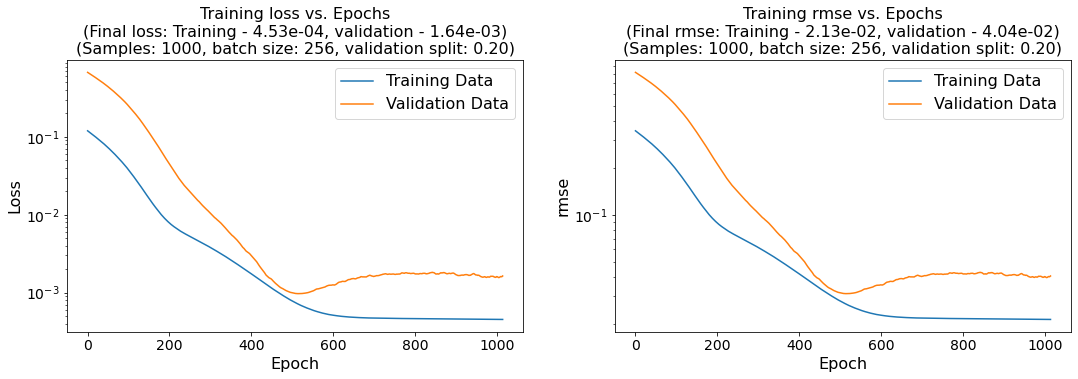

In [49]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

    model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_single  4.7733  0.0321  32.5056  5.7014                    0.5166                0.5164                  0.5166              0.5164                            0.498                       0.4979                          0.498                     0.4979 



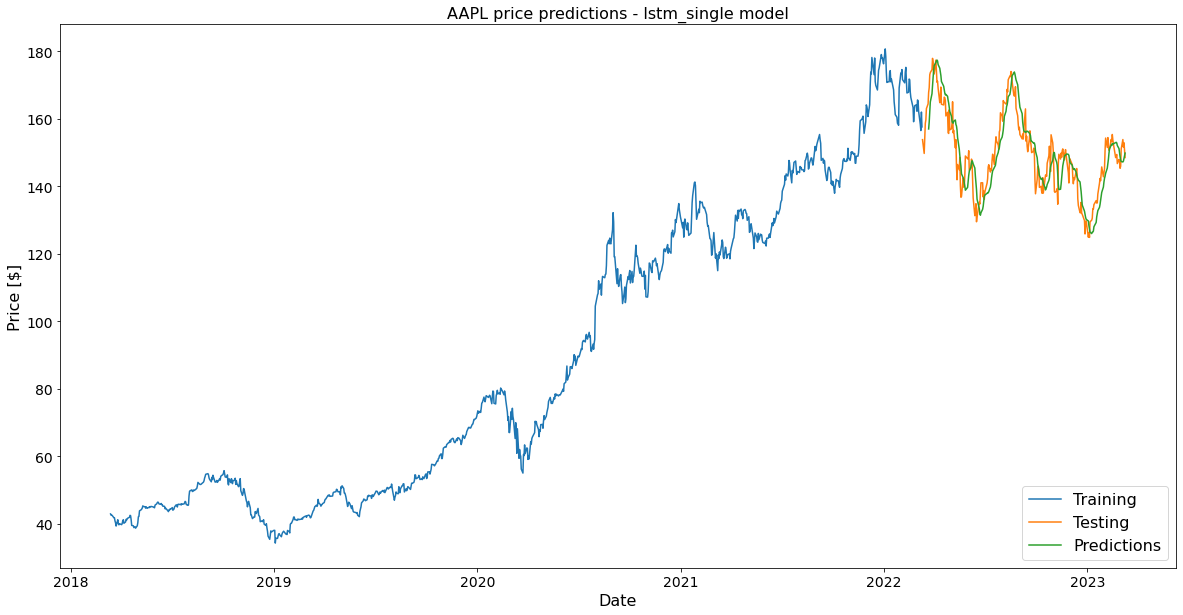

In [50]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## Deep LSTM

### Settings

In [51]:
# General settings
run_model = ml_run_lstm_deep

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [52]:
# Training settings
model_name = 'lstm_deep'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 1e-5
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [53]:
# Data settings
if run_model:
    data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_x = data_for_model['train']['features']
    train_y = data_for_model['train']['targets']
    test_x = data_for_model['test']['features']
    test_y = data_for_model['test']['targets']
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    if explore_data_flag:
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (1000, 7, 1)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 1)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)


In [54]:
# Model settings
if run_model:
    model_is_pytorch = False
    
    model = keras.Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
        LSTM(100, return_sequences=True),
        LSTM(100, return_sequences=False),
        Dense(25, activation=None),
        Dense(1, activation=None, name='output')
        ])

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss='mean_squared_error',
        metrics = training_metrics,
        )

    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 100)            40800     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/2000
4/4 [==============================] - 3s 230ms/step - loss: 0.1297 - rmse: 0.3601 - val_loss: 0.7312 - val_rmse: 0.8551
Epoch 2/2000
4/4 [==============================] - 0s 42ms/step - loss: 0.1280 - rmse: 0.3578 - val_loss: 0.7232 - val_rmse: 0.8504
Epoch 3/2000
4/4 [==============================] - 0s 32ms/step - loss: 0.1263 - rmse: 0.3554 - val_loss: 0.7153 - val_rmse: 0.8458
Epoch 4/2000
4/4 [==============================] - 0s 27ms/step - loss: 0.1247 - rmse: 0.3531 - val_loss: 0.7075 - val_rmse: 0.8411
Epoch 5/2000
4/4 [==============================] - 0s 26ms/step - loss: 0.1231 - rmse: 0.3508 - val_loss: 0.6998 - val_rmse: 0.8365
Epoch 6/2000
4/4 [==============================] - 0s 26ms/step - loss: 0.1215 - rmse: 0.3486 - val_loss: 0.6921 - val_rmse: 0.8319
Epoch 7/2000
4/4 [==============================] - 0s 28ms/step - loss: 0.1199 - rmse: 0.3463 - val_loss: 0.6845 - val_rmse: 0.8274
Epoch 8/2000
4/4 [==============================] - 0s 27ms/step - l

INFO:tensorflow:Assets written to: Models/model_lstm_deep_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_lstm_deep_AAPL_1d/assets



Saved model to:
Models/model_lstm_deep_AAPL_1d/ 

Loaded model from:
Models/model_lstm_deep_AAPL_1d/ 

Presenting model summary:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 7, 100)            40800     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________

Final loss - Training: 4.999e-04, validation: 1.

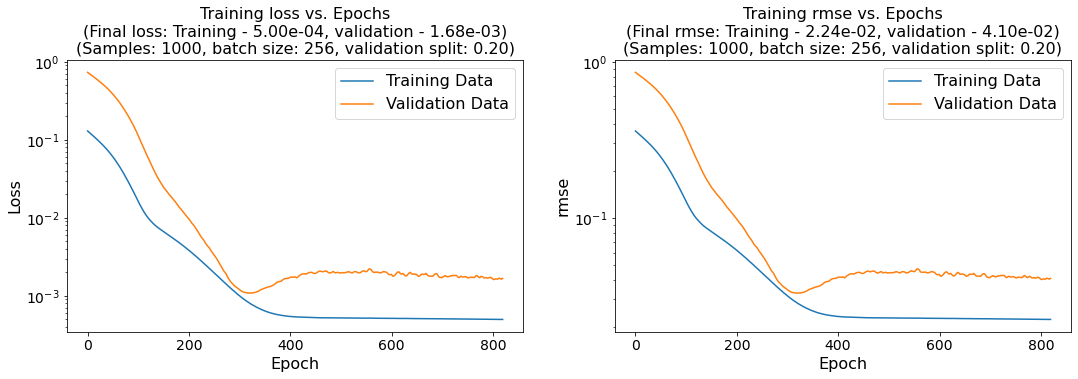

In [55]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

  model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_deep  5.0701  0.0341  36.4791  6.0398                    0.5041                0.5041                  0.5041              0.5041                           0.5062                       0.5062                         0.5062                     0.5062 



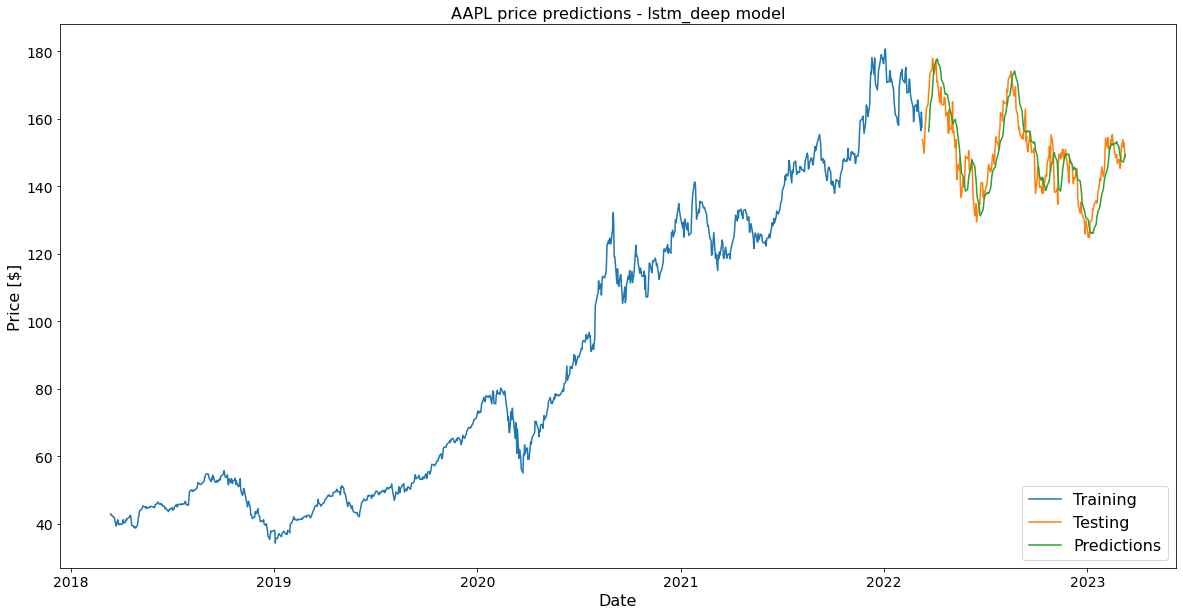

In [56]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## Bidirectional LSTM

### Settings

In [57]:
# General settings
run_model = ml_run_lstm_bidir

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [58]:
# Training settings
model_name = 'lstm_bidir'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 1e-5
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [59]:
# Data settings
if run_model:
    data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_x = data_for_model['train']['features']
    train_y = data_for_model['train']['targets']
    test_x = data_for_model['test']['features']
    test_y = data_for_model['test']['targets']
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    if explore_data_flag:
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (1000, 7, 1)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 1)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)


In [60]:
# Model settings
if run_model:
    model_is_pytorch = False
    
    model = keras.Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
        Bidirectional(LSTM(100, return_sequences=False)),
        Dense(25, activation=None),
        Dense(1, activation=None, name='output')
    ])

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss='mean_squared_error',
        metrics = training_metrics,
        )

    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 25)                5025      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 86,651
Trainable params: 86,651
Non-trainable params: 0
_________________________________________________________________


### Training

Epoch 1/2000
4/4 [==============================] - 4s 327ms/step - loss: 0.1391 - rmse: 0.3730 - val_loss: 0.7772 - val_rmse: 0.8816
Epoch 2/2000
4/4 [==============================] - 0s 34ms/step - loss: 0.1366 - rmse: 0.3697 - val_loss: 0.7651 - val_rmse: 0.8747
Epoch 3/2000
4/4 [==============================] - 0s 32ms/step - loss: 0.1342 - rmse: 0.3664 - val_loss: 0.7531 - val_rmse: 0.8678
Epoch 4/2000
4/4 [==============================] - 0s 37ms/step - loss: 0.1319 - rmse: 0.3631 - val_loss: 0.7412 - val_rmse: 0.8609
Epoch 5/2000
4/4 [==============================] - 0s 34ms/step - loss: 0.1295 - rmse: 0.3599 - val_loss: 0.7295 - val_rmse: 0.8541
Epoch 6/2000
4/4 [==============================] - 0s 42ms/step - loss: 0.1273 - rmse: 0.3567 - val_loss: 0.7179 - val_rmse: 0.8473
Epoch 7/2000
4/4 [==============================] - 0s 37ms/step - loss: 0.1250 - rmse: 0.3535 - val_loss: 0.7066 - val_rmse: 0.8406
Epoch 8/2000
4/4 [==============================] - 0s 31ms/step - l

INFO:tensorflow:Assets written to: Models/model_lstm_bidir_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_lstm_bidir_AAPL_1d/assets



Saved model to:
Models/model_lstm_bidir_AAPL_1d/ 

Loaded model from:
Models/model_lstm_bidir_AAPL_1d/ 

Presenting model summary:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 25)                5025      
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 86,651
Trainable params: 86,651
Non-trainable params: 0
_________________________________________________________________

Final loss - Training: 3.657e-04, validation: 9.654e-04
Final rmse - Training: 1.91e-02, validation: 3.11e-02



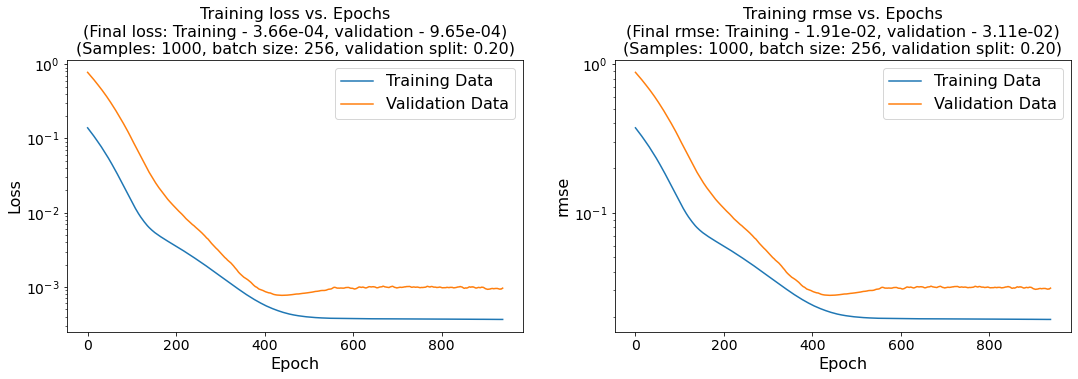

In [61]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

   model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_bidir  4.3428  0.0293  27.3151  5.2264                    0.5122                0.5123                  0.5122              0.5123                           0.5145                       0.5144                         0.5145                     0.5144 



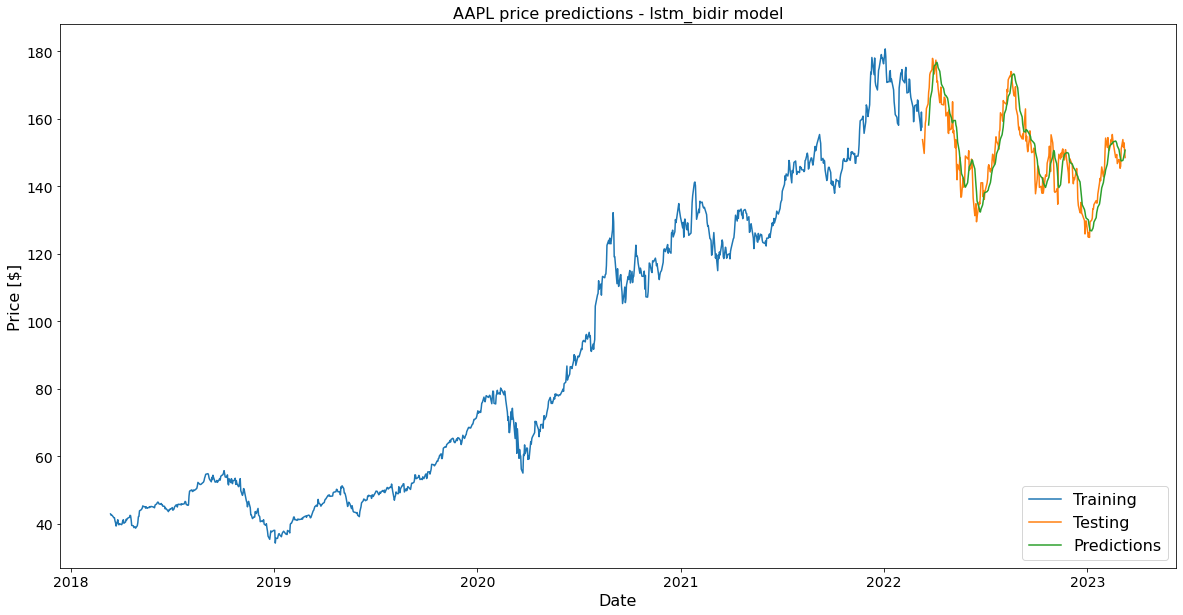

In [62]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## Deep bidirectional LSTM

### Settings

In [63]:
# General settings
run_model = ml_run_lstm_bidir_deep

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [64]:
# Training settings
model_name = 'lstm_bidir_deep'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 1e-5
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [65]:
# Data settings
if run_model:
    data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_x = data_for_model['train']['features']
    train_y = data_for_model['train']['targets']
    test_x = data_for_model['test']['features']
    test_y = data_for_model['test']['targets']
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    if explore_data_flag:
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (1000, 7, 1)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 1)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)


In [66]:
# Model settings
if run_model:
    model_is_pytorch = False
    
    model = keras.Sequential([
        InputLayer(input_shape=(train_x.shape[1], train_y.shape[1])), # [(batch_size,) timesteps, features_dim]
        Bidirectional(LSTM(100, return_sequences=True)),
        Bidirectional(LSTM(100, return_sequences=False)),
        Dense(25, activation=None),
        Dropout(0.2),
        Dense(1, activation=None, name='output')
    ])

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss='mean_squared_error',
        metrics = training_metrics,
        )

    model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 7, 200)           81600     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 25)                5025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 output (Dense)              (None, 1)                 26        
                                                                 
Total params: 327,451
Trainable params: 327,451
Non-tr

### Training

Epoch 1/2000
4/4 [==============================] - 5s 430ms/step - loss: 0.1175 - rmse: 0.3428 - val_loss: 0.6574 - val_rmse: 0.8108
Epoch 2/2000
4/4 [==============================] - 0s 58ms/step - loss: 0.1149 - rmse: 0.3390 - val_loss: 0.6408 - val_rmse: 0.8005
Epoch 3/2000
4/4 [==============================] - 0s 32ms/step - loss: 0.1117 - rmse: 0.3342 - val_loss: 0.6245 - val_rmse: 0.7903
Epoch 4/2000
4/4 [==============================] - 0s 36ms/step - loss: 0.1084 - rmse: 0.3292 - val_loss: 0.6084 - val_rmse: 0.7800
Epoch 5/2000
4/4 [==============================] - 0s 36ms/step - loss: 0.1051 - rmse: 0.3242 - val_loss: 0.5928 - val_rmse: 0.7699
Epoch 6/2000
4/4 [==============================] - 0s 35ms/step - loss: 0.1021 - rmse: 0.3195 - val_loss: 0.5774 - val_rmse: 0.7598
Epoch 7/2000
4/4 [==============================] - 0s 35ms/step - loss: 0.1000 - rmse: 0.3162 - val_loss: 0.5622 - val_rmse: 0.7498
Epoch 8/2000
4/4 [==============================] - 0s 34ms/step - l

INFO:tensorflow:Assets written to: Models/model_lstm_bidir_deep_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_lstm_bidir_deep_AAPL_1d/assets



Saved model to:
Models/model_lstm_bidir_deep_AAPL_1d/ 

Loaded model from:
Models/model_lstm_bidir_deep_AAPL_1d/ 

Presenting model summary:

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 7, 200)           81600     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 25)                5025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 output (Dense)              (None, 1)     

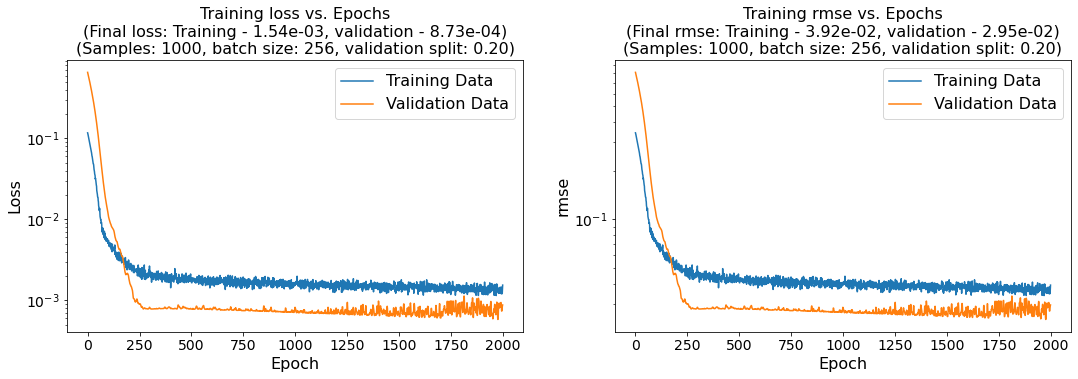

In [67]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

        model_name     mae   mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  lstm_bidir_deep  4.0412  0.027  24.1823  4.9176                    0.5343                0.5328                  0.5343              0.5328                           0.5309                       0.5309                         0.5309                     0.5309 



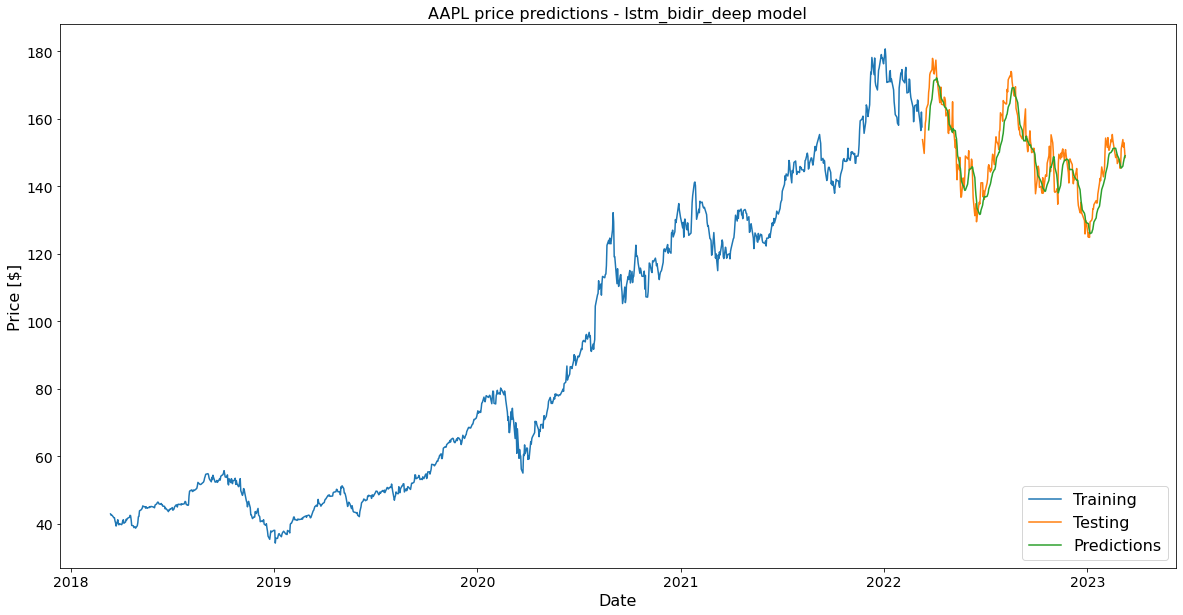

In [68]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## CNN LSTM

### Settings

In [69]:
# General settings
run_model = ml_run_cnn_lstm

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [70]:
# Training settings
model_name = 'cnn_lstm'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 1e-5
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [71]:
# Data settings
if run_model:
    data_for_model = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_x = data_for_model['train']['features']
    train_y = data_for_model['train']['targets']
    test_x = data_for_model['test']['features']
    test_y = data_for_model['test']['targets']
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    if explore_data_flag:
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

train_x.shape = (1000, 7, 1)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 1)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)


In [72]:
# Model settings
if run_model:
    model_is_pytorch = False
    
    num_samples_train = train_x.shape[0] # 947
    num_samples_test = test_x.shape[0] # 191
    num_time_steps_prices = train_x.shape[1] # 60
    num_feats_per_time_step = train_x.shape[2] # 1

    dropout_pct = 0.2

    # Model inputs
    model_input_prices = Input(shape=(num_time_steps_prices, num_feats_per_time_step))

    # CNN
    branch_prices = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(model_input_prices)
    branch_prices = MaxPooling1D(pool_size=2, strides=1, padding='same')(branch_prices)
    branch_prices = Activation('relu')(branch_prices)
    branch_prices = Dropout(dropout_pct)(branch_prices)

    # LSTM
    branch_prices = LSTM(units=64, return_sequences=False)(branch_prices)

    # Model output
    model_output = Dense(1, activation=None, name='output')(branch_prices)

    # Defining the overall model
    model = Model(inputs=model_input_prices, outputs=model_output)

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss = 'mean_absolute_error',
        metrics = training_metrics,
        )

    model.summary(show_trainable=True)

    if run_model and model_save_flag:
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        plot_path = model_folder + f'model_{model_name}.png'
        plot_model(model,
                to_file = plot_path,
                show_shapes = True,
                expand_nested = True,
                show_layer_activations = True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_5 (InputLayer)        [(None, 7, 1)]            0         Y          
                                                                            
 conv1d (Conv1D)             (None, 7, 32)             128       Y          
                                                                            
 max_pooling1d (MaxPooling1D  (None, 7, 32)            0         Y          
 )                                                                          
                                                                            
 activation (Activation)     (None, 7, 32)             0         Y          
                                                                            
 dropout_1 (Dropout)         (None, 7, 32)             0         Y          
                                                             

### Training

Epoch 1/2000
4/4 [==============================] - 4s 194ms/step - loss: 0.2289 - rmse: 0.2970 - val_loss: 0.6991 - val_rmse: 0.7044
Epoch 2/2000
4/4 [==============================] - 0s 28ms/step - loss: 0.2277 - rmse: 0.2956 - val_loss: 0.6970 - val_rmse: 0.7023
Epoch 3/2000
4/4 [==============================] - 0s 29ms/step - loss: 0.2272 - rmse: 0.2954 - val_loss: 0.6949 - val_rmse: 0.7002
Epoch 4/2000
4/4 [==============================] - 0s 28ms/step - loss: 0.2259 - rmse: 0.2939 - val_loss: 0.6928 - val_rmse: 0.6981
Epoch 5/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.2248 - rmse: 0.2925 - val_loss: 0.6907 - val_rmse: 0.6960
Epoch 6/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.2242 - rmse: 0.2920 - val_loss: 0.6885 - val_rmse: 0.6938
Epoch 7/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.2228 - rmse: 0.2905 - val_loss: 0.6864 - val_rmse: 0.6917
Epoch 8/2000
4/4 [==============================] - 0s 21ms/step - l

INFO:tensorflow:Assets written to: Models/model_cnn_lstm_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_cnn_lstm_AAPL_1d/assets



Saved model to:
Models/model_cnn_lstm_AAPL_1d/ 

Loaded model from:
Models/model_cnn_lstm_AAPL_1d/ 

Presenting model summary:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 7, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 32)            0         
 )                                                               
                                                                 
 activation (Activation)     (None, 7, 32)             0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 32)             0         
                                                                

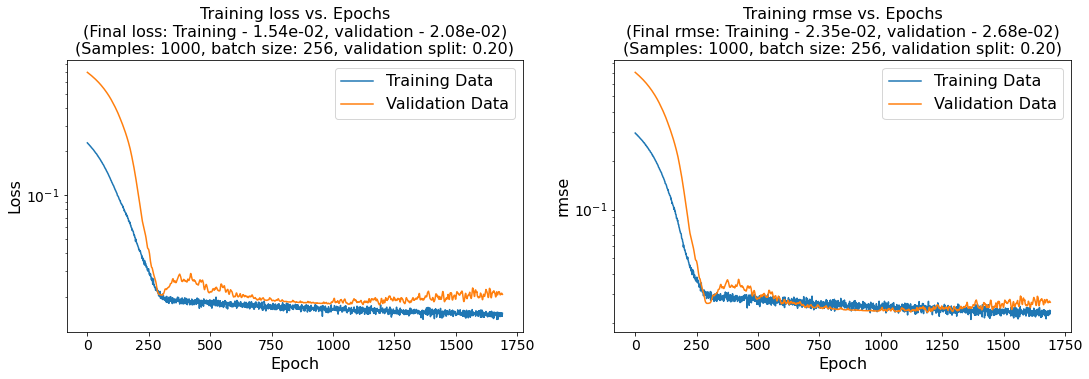

In [73]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

  model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0   cnn_lstm  3.8011  0.0257  22.0444  4.6951                    0.4913                0.4918                  0.4913              0.4918                           0.5226                       0.5226                         0.5226                     0.5226 



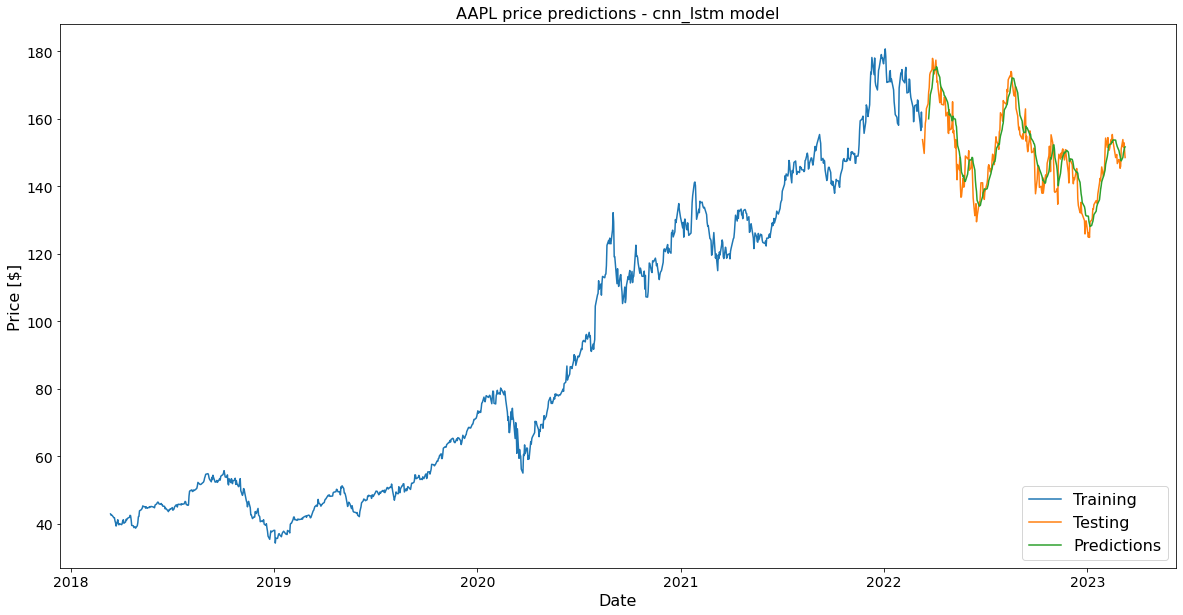

In [74]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## CNN LSTM - multiple features

### Settings

In [75]:
# General settings
run_model = ml_run_cnn_lstm_multiple_feats

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [76]:
# Training settings
model_name = 'cnn_lstm_multiple_feats'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 1e-5
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [77]:
# Data settings
if run_model:
    # Constants
    num_samples_train = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train']['features'])
    num_samples_test = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['test']['features'])
    num_time_steps = data_lookback_steps
    num_features = len(data_features_names)
    num_targets = 1

    # Features
    data_symbol = data_feats_and_targets_preprocessed[data_symbol_eg]
    train_x = []
    test_x = []
    for feature_type in data_features_names:
        data_symbol_feature = data_symbol[feature_type]
        train_x.append( data_symbol_feature['train']['features'].reshape(num_samples_train, num_time_steps) )
        test_x.append( data_symbol_feature['test']['features'].reshape(num_samples_test, num_time_steps) )
    train_x = np.stack(train_x, axis=2)
    test_x = np.stack(test_x, axis=2)
   
    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    # Targets
    data_for_targets = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_y = data_for_targets['train']['targets']
    test_y = data_for_targets['test']['targets']

    # Scalers
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    if explore_data_flag:
        print('data_features_names =', data_features_names)
        print()
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)
        print()

        # for i in range(0,6): # Feature
        #     for j in range(0,3): # Sample
        #         plt.figure(figsize=(5,3))
        #         plt.plot(train_x[j,:,i])
        #         plt.show()
        #     print('\n\n\n')

data_features_names = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

train_x.shape = (1000, 7, 6)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 6)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)



In [78]:
# Model settings
if run_model:
    model_is_pytorch = False
    dropout_pct = 0.2

    # Model inputs
    model_input_prices = Input(shape=(num_time_steps, num_features))

    # CNN
    branch_prices = Conv1D(filters=64, kernel_size=3, activation='tanh', padding='same')(model_input_prices)
    branch_prices = MaxPooling1D(pool_size=2, strides=1, padding='same')(branch_prices)
    branch_prices = Activation('relu')(branch_prices)
    branch_prices = Dropout(dropout_pct)(branch_prices)

    # LSTM
    branch_prices = LSTM(units=64, return_sequences=False)(branch_prices)

    # Model output
    model_output = Dense(1, activation=None, name='output')(branch_prices)

    # Defining the overall model
    model = Model(inputs=model_input_prices, outputs=model_output)

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss = 'mean_absolute_error',
        metrics = training_metrics,
        )

    model.summary(show_trainable=True)

    if run_model and model_save_flag:
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        plot_path = model_folder + f'model_{model_name}.png'
        plot_model(model,
                to_file = plot_path,
                show_shapes = True,
                expand_nested = True,
                show_layer_activations = True)

Model: "model_1"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_6 (InputLayer)        [(None, 7, 6)]            0         Y          
                                                                            
 conv1d_1 (Conv1D)           (None, 7, 64)             1216      Y          
                                                                            
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         Y          
 1D)                                                                        
                                                                            
 activation_1 (Activation)   (None, 7, 64)             0         Y          
                                                                            
 dropout_2 (Dropout)         (None, 7, 64)             0         Y          
                                                           

### Training

Epoch 1/2000
4/4 [==============================] - 2s 194ms/step - loss: 0.2757 - rmse: 0.3453 - val_loss: 0.7697 - val_rmse: 0.7758
Epoch 2/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.2737 - rmse: 0.3436 - val_loss: 0.7646 - val_rmse: 0.7706
Epoch 3/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.2718 - rmse: 0.3414 - val_loss: 0.7594 - val_rmse: 0.7654
Epoch 4/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.2699 - rmse: 0.3393 - val_loss: 0.7543 - val_rmse: 0.7603
Epoch 5/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.2678 - rmse: 0.3368 - val_loss: 0.7491 - val_rmse: 0.7551
Epoch 6/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.2653 - rmse: 0.3341 - val_loss: 0.7440 - val_rmse: 0.7500
Epoch 7/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.2635 - rmse: 0.3318 - val_loss: 0.7389 - val_rmse: 0.7448
Epoch 8/2000
4/4 [==============================] - 0s 21ms/step - l

INFO:tensorflow:Assets written to: Models/model_cnn_lstm_multiple_feats_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_cnn_lstm_multiple_feats_AAPL_1d/assets



Saved model to:
Models/model_cnn_lstm_multiple_feats_AAPL_1d/ 

Loaded model from:
Models/model_cnn_lstm_multiple_feats_AAPL_1d/ 

Presenting model summary:

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             1216      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 activation_1 (Activation)   (None, 7, 64)             0         
                                                                 
 dropout_2 (Dropout)         (None, 7, 64)             0         
                                

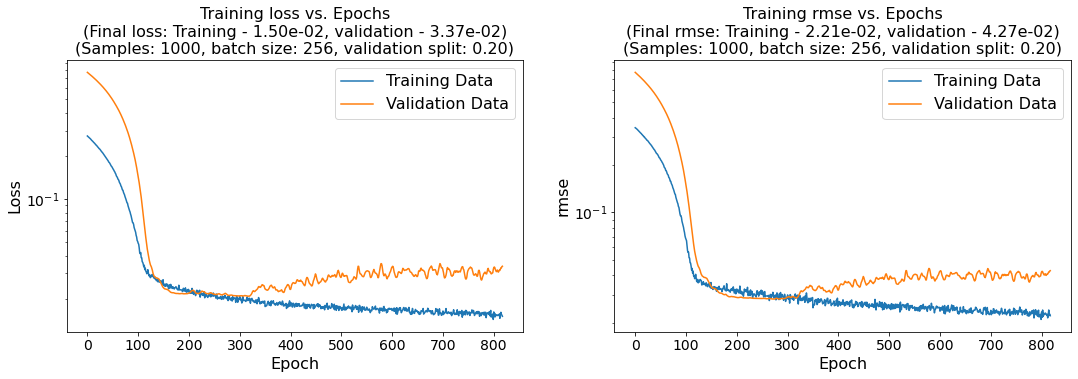

In [79]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

                model_name     mae    mape      mse   rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  cnn_lstm_multiple_feats  3.7642  0.0253  22.1933  4.711                    0.5702                0.5697                  0.5702              0.5697                           0.4773                       0.4774                         0.4773                     0.4774 



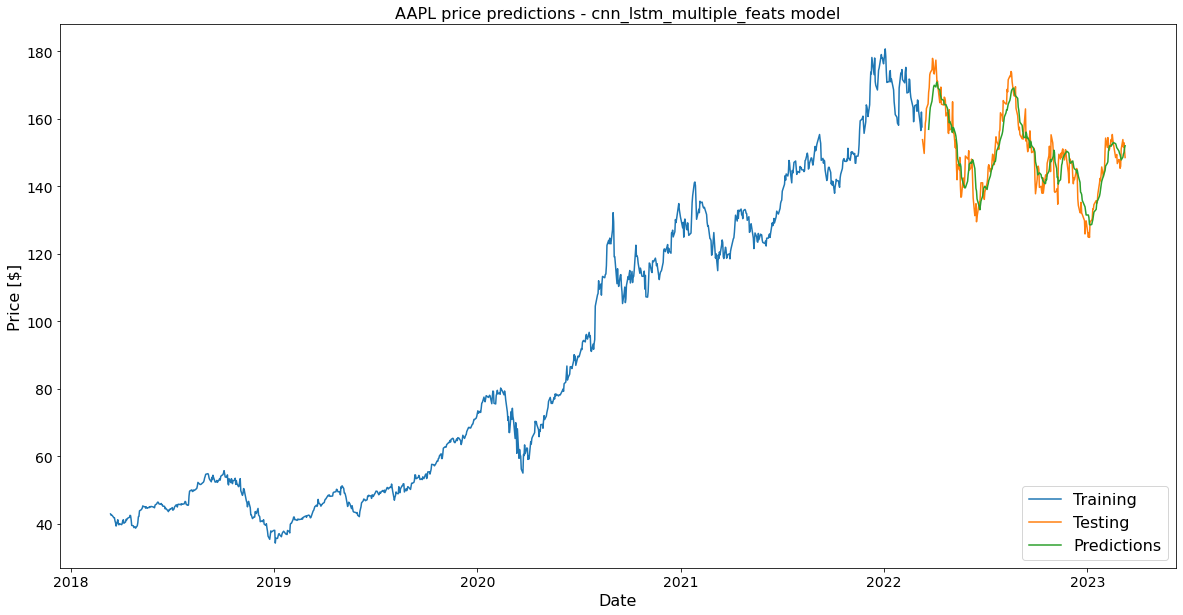

In [80]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## CNN deep bidirectional LSTM - multiple features

### Settings

In [81]:
# General settings
run_model = ml_run_cnn_lstm_deep_bidir_multiple_feats

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [82]:
# Training settings
model_name = 'cnn_deep_bidir_lstm_multiple_feats'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_learning_rate = 3e-6
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [83]:
# Data settings
if run_model:
    model_is_pytorch = False
    
    # Constants
    num_samples_train = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train']['features'])
    num_samples_test = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['test']['features'])
    num_time_steps = data_lookback_steps
    num_features = len(data_features_names)
    num_targets = 1

    # Features
    data_symbol = data_feats_and_targets_preprocessed[data_symbol_eg]
    train_x = []
    test_x = []
    for feature_type in data_features_names:
        data_symbol_feature = data_symbol[feature_type]
        train_x.append( data_symbol_feature['train']['features'].reshape(num_samples_train, num_time_steps) )
        test_x.append( data_symbol_feature['test']['features'].reshape(num_samples_test, num_time_steps) )
    train_x = np.stack(train_x, axis=2)
    test_x = np.stack(test_x, axis=2)
   
    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    # Targets
    data_for_targets = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_y = data_for_targets['train']['targets']
    test_y = data_for_targets['test']['targets']

    # Scalers
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    if explore_data_flag:
        print('data_features_names =', data_features_names)
        print()
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)
        print()

        # for i in range(0,6): # Feature
        #     for j in range(0,3): # Sample
        #         plt.figure(figsize=(5,3))
        #         plt.plot(train_x[j,:,i])
        #         plt.show()
        #     print('\n\n\n')

data_features_names = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

train_x.shape = (1000, 7, 6)
train_y.shape = (1000, 1, 1)
test_x.shape = (244, 7, 6)
test_y.shape = (244, 1, 1)

test_x_unprocessed.shape = (244, 7, 1)



In [84]:
# Model settings
if run_model:
    dropout_pct = 0.2

    # Model inputs
    model_input_prices = Input(shape=(num_time_steps, num_features))

    # CNN
    branch_prices = Conv1D(filters=64, kernel_size=3, activation='tanh', padding='same')(model_input_prices)
    branch_prices = MaxPooling1D(pool_size=2, strides=1, padding='same')(branch_prices)
    branch_prices = Activation('relu')(branch_prices)
    branch_prices = Dropout(dropout_pct)(branch_prices)

    # LSTM
    branch_prices = Bidirectional(LSTM(100, return_sequences=True))(branch_prices)
    branch_prices = Bidirectional(LSTM(100, return_sequences=False))(branch_prices)

    # Model output
    model_output = Dense(1, activation=None, name='output')(branch_prices)

    # Defining the overall model
    model = Model(inputs=model_input_prices, outputs=model_output)

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss = 'mean_absolute_error',
        metrics = training_metrics,
        )

    model.summary(show_trainable=True)

    if run_model and model_save_flag:
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        plot_path = model_folder + f'model_{model_name}.png'
        plot_model(model,
                to_file = plot_path,
                show_shapes = True,
                expand_nested = True,
                show_layer_activations = True)

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_7 (InputLayer)        [(None, 7, 6)]            0         Y          
                                                                            
 conv1d_2 (Conv1D)           (None, 7, 64)             1216      Y          
                                                                            
 max_pooling1d_2 (MaxPooling  (None, 7, 64)            0         Y          
 1D)                                                                        
                                                                            
 activation_2 (Activation)   (None, 7, 64)             0         Y          
                                                                            
 dropout_3 (Dropout)         (None, 7, 64)             0         Y          
                                                           

### Training

Epoch 1/2000
4/4 [==============================] - 6s 429ms/step - loss: 0.2520 - rmse: 0.3278 - val_loss: 0.7799 - val_rmse: 0.7862
Epoch 2/2000
4/4 [==============================] - 0s 60ms/step - loss: 0.2503 - rmse: 0.3259 - val_loss: 0.7764 - val_rmse: 0.7827
Epoch 3/2000
4/4 [==============================] - 0s 43ms/step - loss: 0.2487 - rmse: 0.3238 - val_loss: 0.7729 - val_rmse: 0.7792
Epoch 4/2000
4/4 [==============================] - 0s 45ms/step - loss: 0.2478 - rmse: 0.3233 - val_loss: 0.7695 - val_rmse: 0.7757
Epoch 5/2000
4/4 [==============================] - 0s 45ms/step - loss: 0.2462 - rmse: 0.3212 - val_loss: 0.7660 - val_rmse: 0.7722
Epoch 6/2000
4/4 [==============================] - 0s 45ms/step - loss: 0.2443 - rmse: 0.3191 - val_loss: 0.7626 - val_rmse: 0.7688
Epoch 7/2000
4/4 [==============================] - 0s 44ms/step - loss: 0.2431 - rmse: 0.3179 - val_loss: 0.7591 - val_rmse: 0.7653
Epoch 8/2000
4/4 [==============================] - 0s 46ms/step - l

INFO:tensorflow:Assets written to: Models/model_cnn_deep_bidir_lstm_multiple_feats_AAPL_1d/assets


INFO:tensorflow:Assets written to: Models/model_cnn_deep_bidir_lstm_multiple_feats_AAPL_1d/assets



Saved model to:
Models/model_cnn_deep_bidir_lstm_multiple_feats_AAPL_1d/ 

Loaded model from:
Models/model_cnn_deep_bidir_lstm_multiple_feats_AAPL_1d/ 

Presenting model summary:

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 64)             1216      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 activation_2 (Activation)   (None, 7, 64)             0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 64)             0         
          

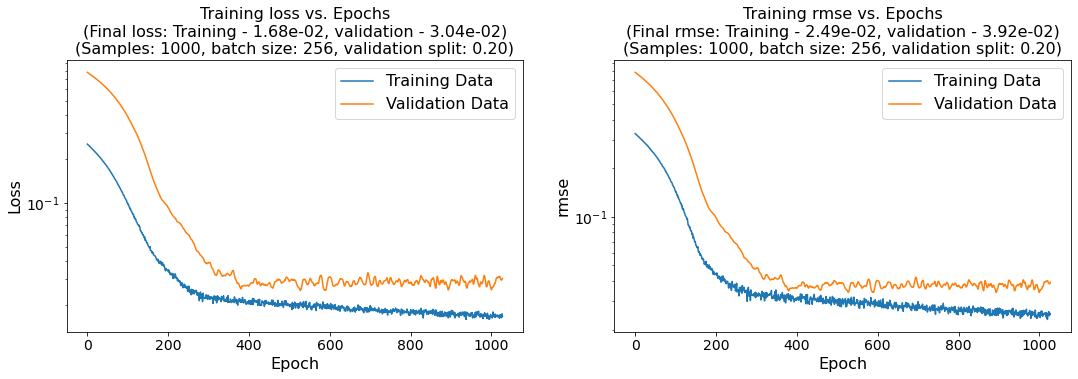

In [85]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = train_x,
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating


Presenting evaluation metrics:

                           model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  cnn_deep_bidir_lstm_multiple_feats  4.5818  0.0305  31.9664  5.6539                    0.5386                0.5369                  0.5386              0.5369                           0.5186                       0.5185                         0.5186                     0.5185 



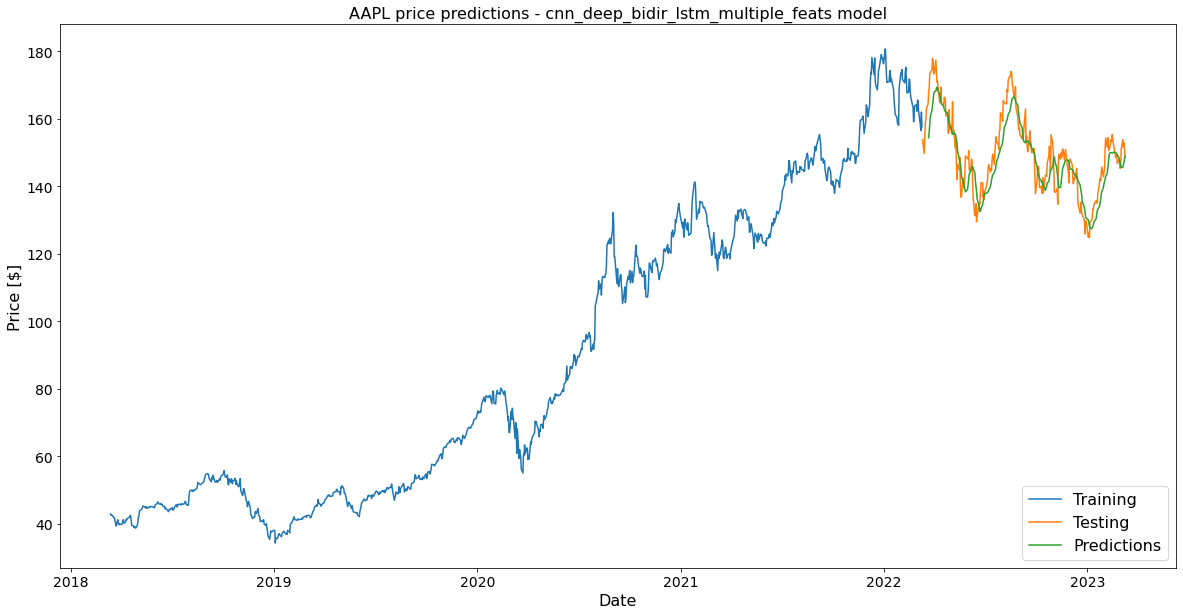

In [86]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## CNN LSTM - multiple features (PyTorch)

### Settings

In [87]:
run_model = ml_run_cnn_lstm_multiple_feats_pytorch

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [88]:
# Training settings
model_name = 'cnn_lstm_multiple_feats_pytorch'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

training_epochs = 11 # Stopping early manually, at the epoch of the best evaluation metrics
training_batch_size = 1
training_validation_split = 0.2
training_learning_rate = 1e-5

# # Best trend balanced accuracy
# data_symbols = ['AAPL]
# [data_start_date, data_end_date] = [2018-03-13, 2023-03-12 00:00:00]
# random_seed_value = 42
# training_epochs = 11
# training_batch_size = 1
# training_validation_split = 0.2
# training_learning_rate = 1e-5

data_features_names = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

train_x.shape = torch.Size([1000, 6, 7])
train_y.shape = torch.Size([1000, 1, 1])
test_x.shape = torch.Size([244, 6, 7])
test_y.shape = torch.Size([244, 1, 1])
test_x_unprocessed.shape = torch.Size([244, 7, 1])

Verifying samples:



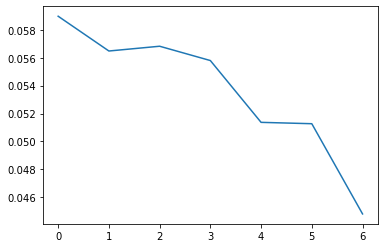

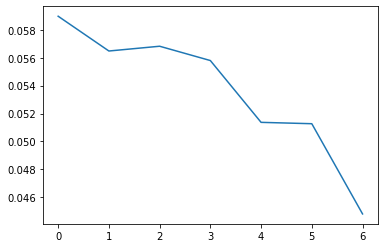

In [89]:
# Data settings
if run_model:
    # Constants
    num_samples_train = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train']['features'])
    num_samples_test = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['test']['features'])
    num_time_steps = data_lookback_steps
    num_features = len(data_features_names)
    num_targets = 1

    # Features
    data_symbol = data_feats_and_targets_preprocessed[data_symbol_eg]
    train_x = []
    test_x = []
    for feature_type in data_features_names:
        data_symbol_feature = data_symbol[feature_type]
        train_x.append( data_symbol_feature['train']['features'].reshape(num_samples_train, num_time_steps) )
        test_x.append( data_symbol_feature['test']['features'].reshape(num_samples_test, num_time_steps) )
    train_x = np.stack(train_x, axis=1)
    test_x = np.stack(test_x, axis=1)
   
    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    # Targets
    data_for_targets = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_y = data_for_targets['train']['targets']
    test_y = data_for_targets['test']['targets']
    
    # Converting to Tensors
    train_x = Variable(torch.from_numpy(train_x).float())
    train_y = Variable(torch.from_numpy(train_y).float())
    test_x = Variable(torch.from_numpy(test_x).float())
    test_y = Variable(torch.from_numpy(test_y).float())
    test_x_unprocessed = Variable(torch.from_numpy(test_x_unprocessed))

    # Scalers
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    if explore_data_flag:
        print('data_features_names =', data_features_names)
        print()
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)
        print()
        
        # Verifying samples
        print('Verifying samples:\n')
        i_sample = 0
        channel_of_adj_close = 0
        plt.plot(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train']['features'][i_sample])
        plt.show()

        plt.plot(train_x[i_sample, channel_of_adj_close, :])
        plt.show()

        # for i in range(0,6): # Feature
        #     for j in range(0,3): # Sample
        #         plt.figure(figsize=(5,3))
        #         plt.plot(train_x[j,:,i])
        #         plt.show()
        #     print('\n\n\n')

### Architecture

In [90]:
# Model settings
if run_model:
    model_is_pytorch = True

    class ModelPyTorch(nn.Module):
        def __init__(self, device, num_features, num_time_steps):
            # Access properties & methods of a parent/sibling class
            super(ModelPyTorch, self).__init__()

            self.cnn = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3,
                stride=1, padding='same') # Input: (batch_size, channels_num, sequence_length)
            self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1, padding=1)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0)
            
            self.lstm_input_size = 8 # Not 7 because of the maxpool padding
            self.lstm_hidden_size = 64
            self.lstm_num_layers = 1
            self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=self.lstm_hidden_size,
                num_layers=1, batch_first=True) # Input: (batch_size, sequence_length, input_size)

            self.fc = nn.Linear(in_features=64, out_features=1)
        
        def forward(self, x):
            ''' Propagate input through model. '''
            print_shapes = False

            if print_shapes:
                print('Presenting layers\' output shapes:\n')
                print('x',x.shape)
            out = self.cnn(x)
            if print_shapes:
                print('cnn',out.shape)
            out = self.maxpool(out)
            if print_shapes:
                print('pool',out.shape)
            out = self.relu(out)
            if print_shapes:
                print('relu',out.shape)
            out = self.dropout(out)
            if print_shapes:
                print('dropout',out.shape)

            # Initializing cell state
            # Cell input: (num_LSTM_layers, x.size(0), self.hidden_size)
            c0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_size) \
                .requires_grad_(True).to(device)
            # Initializing hidden state / activation
            h0 = torch.zeros(self.lstm_num_layers, x.size(0), self.lstm_hidden_size) \
                .requires_grad_(True).to(device)
            # Initializing LSTM and detaching the input tensors from the computation graph,
            # so that backpropagation will not proceed beyond the batch
            # LSTM input: (batch size, time steps, values per time step)
            # LSTM output: (output - all h_t from the last layer for each time,
            #               hn - final hidden state for each sequence element,
            #               cn - final cell state for each sequence element)
            lstm_output, (hn, cn) = self.lstm(out, (h0.detach(), c0.detach()))
            if print_shapes:
                print('hn',hn.shape)
            out = hn

            # Reshaping data for the FC layer
            out = out.reshape(-1, self.lstm_hidden_size)
            if print_shapes:
                print('reshape',out.shape)
            out = self.fc(out)
            if print_shapes:
                print('fc',out.shape)
            if print_shapes:
                print()
                sys.exit()
            
            return out

    model = ModelPyTorch(device = device, num_features=train_x.shape[1], num_time_steps=train_x.shape[2])
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=training_learning_rate)

    print('Model structure:\n')
    print(model, '\n')
    # print('Model parameters:\n')
    # for name, param in model.named_parameters():
    #     print(f'Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n')

Model structure:

ModelPyTorch(
  (cnn): Conv1d(6, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0, inplace=False)
  (lstm): LSTM(8, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
) 



### Training

C:\Users\Sergey\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\Sergey\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([200, 1, 1])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch: 0, train loss: 0.00098, validation loss: 0.17433
Epoch: 2, train loss: 0.04796, validation loss: 0.10423
Epoch: 4, train loss: 0.00936, validation loss: 0.15003
Epoch: 6, train loss: 0.00103, validation loss: 0.17018
Epoch: 8, train loss: 0.00009, validation loss: 0.17317
Epoch: 10, train loss: 0.00000, validation loss: 0.17409



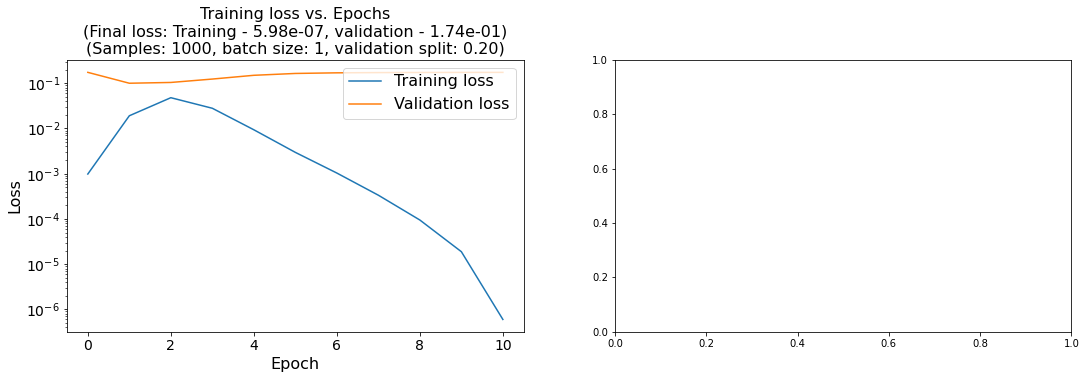

In [91]:
# Training
if run_model:
    # Using GPU if available
    train_x, train_y = train_x.to(device), train_y.to(device)
    test_x, test_y, test_x_unprocessed = test_x.to(device), test_y.to(device), test_x_unprocessed.to(device)
    model.to(device)

    if False and explore_data_flag:
        print('Presenting devices of variables:\n')
        print('train_x.is_cuda =', train_x.is_cuda)
        print('train_y.is_cuda =', train_y.is_cuda)
        print('test_x.is_cuda =', test_x.is_cuda)
        print('test_y.is_cuda =', test_y.is_cuda)
        print('test_x_unprocessed.is_cuda =', test_x_unprocessed.is_cuda)
        print()
        
    # Training
    train_model_pytorch(train_x, train_y, model, loss_function, optimizer,
        training_epochs, training_batch_size, training_validation_split)

### Evaluating


Presenting evaluation metrics:

                        model_name     mae    mape      mse    rmse  trend_start_bal_accuracy  trend_start_accuracy  trend_end_bal_accuracy  trend_end_accuracy  trend_consec_start_bal_accuracy  trend_consec_start_accuracy  trend_consec_end_bal_accuracy  trend_consec_end_accuracy
0  cnn_lstm_multiple_feats_pytorch  4.6442  0.0313  35.1198  5.9262                    0.5522                0.5533                  0.5522              0.5533                           0.5062                       0.5062                         0.5062                     0.5062 



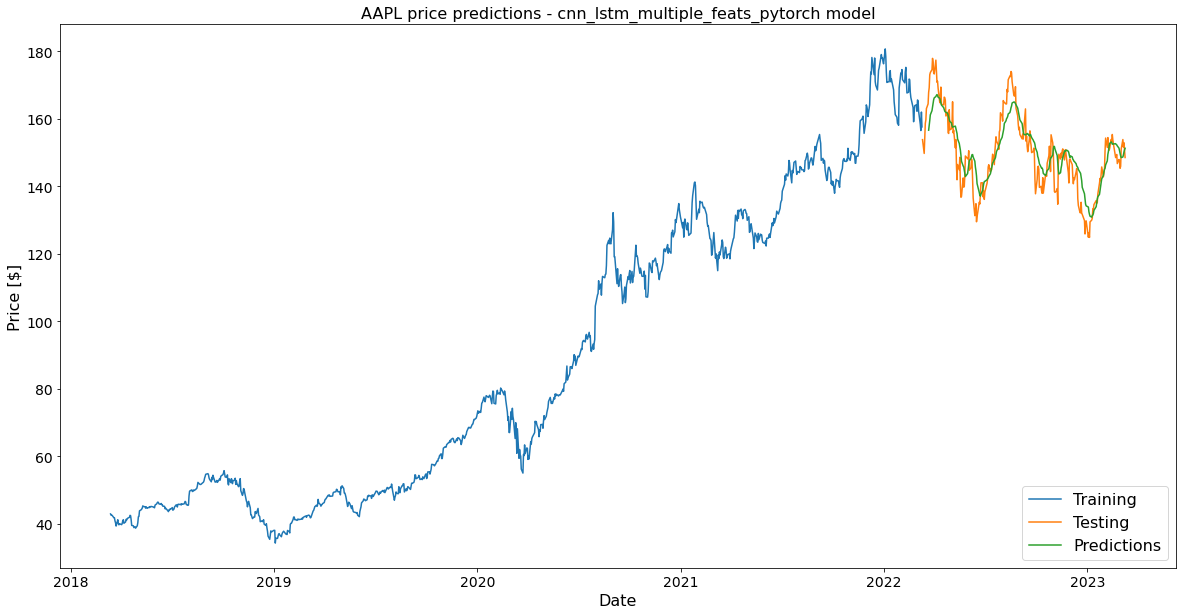

In [92]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = test_x_unprocessed,
        test_x = test_x,
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

## [TO-DO] CNN LSTM - prices & indicators

### Settings

In [93]:
# General settings
run_model = ml_run_cnn_lstm_prices_indics

# Applying randomization settings
if use_fixed_random_seed_flag:
    set_random_seed(random_seed_value)

In [94]:
# Training settings
model_name = 'cnn_lstm_prices_indics'
model_train_flag = ml_train_flag
model_save_flag = ml_save_flag
model_load_flag = ml_load_flag
model_folder = f'Models/model_{model_name}_{data_symbol_eg}_{data_time_interval}/'.replace("'","")

outputs_names = ['output']
training_epochs = 2000
training_batch_size = 256
training_validation_split = 0.2
training_verbose = 1
training_callbacks = EarlyStopping(
    monitor = 'val_loss', mode = 'min', restore_best_weights = True, patience = 500)

show_model_summary = True
plot_training_loss = True
plot_training_metric = True
training_metrics = {'output': tf.keras.metrics.RootMeanSquaredError(name='rmse')}
plot_training_metric_names = {'output': 'rmse'}
plot_log_scale = True

In [95]:
# Data settings
if run_model:
    # Constants
    num_samples_train = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['train']['features'])
    num_samples_test = \
        len(data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']['test']['features'])
    num_time_steps = data_lookback_steps
    num_features = len(data_features_names)
    num_targets = 1

    # Features
    data_symbol = data_feats_and_targets_preprocessed[data_symbol_eg]
    train_x = []
    test_x = []
    for feature_type in data_features_names:
        data_symbol_feature = data_symbol[feature_type]
        train_x.append( data_symbol_feature['train']['features'].reshape(num_samples_train, num_time_steps) )
        test_x.append( data_symbol_feature['test']['features'].reshape(num_samples_test, num_time_steps) )
    train_x = np.stack(train_x, axis=2)
    test_x = np.stack(test_x, axis=2)
   
    test_x_unprocessed = data_feats_and_targets[data_symbol_eg]['Adj Close']['test']['features'] # For evaluation

    # Targets
    data_for_targets = data_feats_and_targets_preprocessed[data_symbol_eg]['Adj Close']
    train_y = data_for_targets['train']['targets']
    test_y = data_for_targets['test']['targets']

    # Scalers
    scaler = scalers[data_symbol_eg]['Adj Close'] # For unscaling the output

    if explore_data_flag:
        print('train_x.shape =', train_x.shape)
        print('train_y.shape =', train_y.shape)
        print('test_x.shape =', test_x.shape)
        print('test_y.shape =', test_y.shape)
        print()
        print('test_x_unprocessed.shape =', test_x_unprocessed.shape)

        # for i in range(0,6): # feat
        #     for j in range(0,3): # sample
        #         plt.figure(figsize=(5,3))
        #         plt.plot(train_x[j,:,i])
        #         plt.show()
        #     print('\n\n\n')

In [96]:
# Model settings
if run_model:
    num_samples_train = train_x.shape[0] # 947
    num_samples_test = test_x.shape[0] # 191
    num_time_steps_prices = train_x.shape[1] # 60
    num_time_steps_indics = 60 # WIP
    num_feats_per_time_step = train_x.shape[2] # 1

    dropout_pct = 0.2

    # Model inputs
    model_input_prices = Input(shape=(num_time_steps_prices, num_feats_per_time_step))
    model_input_indics = Input(shape=(num_time_steps_indics, num_feats_per_time_step))

    # Prices branch
    branch_prices = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(model_input_prices)
    branch_prices = MaxPooling1D(2, padding='same')(branch_prices)
    branch_prices = Dropout(dropout_pct)(branch_prices)

    branch_prices = Bidirectional(LSTM(64, return_sequences=True))(branch_prices)
    branch_prices = Bidirectional(LSTM(64, return_sequences=False))(branch_prices)

    branch_prices = Model(inputs=model_input_prices, outputs=branch_prices)

    # Indicators branch
    branch_indics = Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same')(model_input_indics)
    branch_indics = MaxPooling1D(2, padding='same')(branch_indics)
    branch_indics = Dropout(dropout_pct)(branch_indics)

    branch_indics = Bidirectional(LSTM(64, return_sequences=True))(branch_indics)
    branch_indics = Bidirectional(LSTM(64, return_sequences=False))(branch_indics)

    branch_indics = Model(inputs=model_input_indics, outputs=branch_indics)

    # Combining the branches
    branch_combined = concatenate([branch_prices.output, branch_indics.output])
    branch_combined = Dense(25, activation='linear')(branch_combined)
    branch_combined = Dropout(dropout_pct)(branch_combined)

    # Model output
    model_output = Dense(1, activation='linear', name='output')(branch_combined)

    # Defining the overall model
    model = Model(inputs=[model_input_prices, model_input_indics], outputs=model_output)

    model.compile(
        optimizer = Adam(learning_rate=training_learning_rate),
        loss='mean_squared_error',
        metrics = training_metrics,
        )

    model.summary(show_trainable=True)

    if run_model and model_save_flag:
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        plot_model(model,
                to_file = model_folder + f'model_{model_name}.png',
                show_shapes = True,
                expand_nested = True,
                show_layer_activations = True)

### Training

In [97]:
# Training model
if run_model:
    model, train_history = train_model(
        model = model,
        outputs_names = outputs_names,
        train_x = [train_x, train_x], # [train_x_prices, train_x_indics]
        train_y = train_y,

        model_train_flag = model_train_flag,
        model_save_flag = model_save_flag,
        model_load_flag = model_load_flag,
        model_folder = model_folder,

        training_epochs = training_epochs,
        training_batch_size = training_batch_size,
        training_validation_split = training_validation_split,
        training_verbose = training_verbose,
        training_callbacks = training_callbacks,
        
        show_model_summary = show_model_summary,
        plot_training_loss = plot_training_loss,
        plot_training_metric = plot_training_metric,
        plot_training_metric_names = plot_training_metric_names,
        plot_log_scale = plot_log_scale
        )

### Evaluating

In [98]:
if run_model:
    eval_metrics, pred_y_unscaled = evaluate_model(
        model_is_pytorch = model_is_pytorch,
        model = model,
        model_name = model_name,
        test_x_unprocessed = [test_x_unprocessed, test_x_unprocessed],
        test_x = [train_x, train_x],
        test_y = test_y,
        scaler = scaler,
        data_original = data_original,
        train_test_split = data_train_test_split,
        lookback_steps = data_lookback_steps,
        show_eval = True,
        plot_predictions = True
        )
    
    eval_metrics_all = pd.concat([eval_metrics_all, eval_metrics])

# Evaluation summary

In [99]:
# Summarizing models evaluation
eval_metrics_all = eval_metrics_all.reset_index(drop=True) \
    .sort_values('trend_end_bal_accuracy', ascending=False) \
    .sort_values('mse', ascending=True)

# Saving evaluation
if not os.path.exists(evaluation_saving_folder):
    os.makedirs(evaluation_saving_folder)
eval_metrics_all.to_csv(evaluation_saving_path) 
print(f'Saving evaluations to:\n{evaluation_saving_path}\n')

display(eval_metrics_all)

Saving evaluations to:
Evaluations/evaluation_AAPL_1d_230313.csv



,model_name,mae,mape,mse,rmse,trend_start_bal_accuracy,trend_start_accuracy,trend_end_bal_accuracy,trend_end_accuracy,trend_consec_start_bal_accuracy,trend_consec_start_accuracy,trend_consec_end_bal_accuracy,trend_consec_end_accuracy
4,cnn_lstm,3.8011,0.0257,22.0444,4.6951,0.4913,0.4918,0.4913,0.4918,0.5226,0.5226,0.5226,0.5226
5,cnn_lstm_multiple_feats,3.7642,0.0253,22.1933,4.7110,0.5702,0.5697,0.5702,0.5697,0.4773,0.4774,0.4773,0.4774
3,lstm_bidir_deep,4.0412,0.0270,24.1823,4.9176,0.5343,0.5328,0.5343,0.5328,0.5309,0.5309,0.5309,0.5309
2,lstm_bidir,4.3428,0.0293,27.3151,5.2264,0.5122,0.5123,0.5122,0.5123,0.5145,0.5144,0.5145,0.5144
6,cnn_deep_bidir_lstm_multiple_feats,4.5818,0.0305,31.9664,5.6539,0.5386,0.5369,0.5386,0.5369,0.5186,0.5185,0.5186,0.5185
0,lstm_single,4.7733,0.0321,32.5056,5.7014,0.5166,0.5164,0.5166,0.5164,0.4980,0.4979,0.4980,0.4979
7,cnn_lstm_multiple_feats_pytorch,4.6442,0.0313,35.1198,5.9262,0.5522,0.5533,0.5522,0.5533,0.5062,0.5062,0.5062,0.5062
1,lstm_deep,5.0701,0.0341,36.4791,6.0398,0.5041,0.5041,0.5041,0.5041,0.5062,0.5062,0.5062,0.5062
